# 1. Предобработка

In [1]:
import pandas as pd
df = pd.read_csv('SpotifyFeatures.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


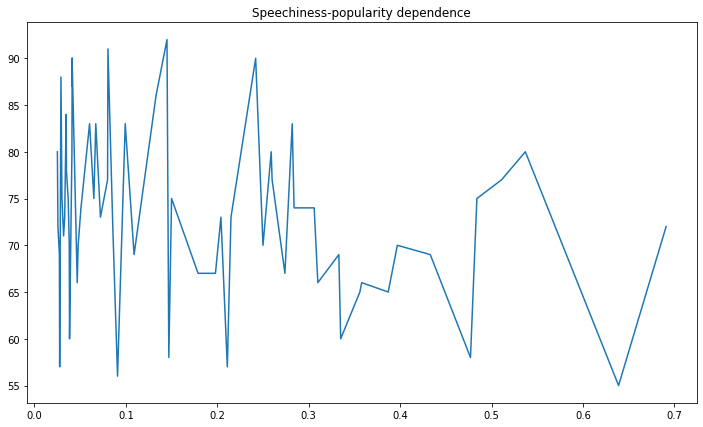

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 7)

spl = df[df['artist_name'] == 'XXXTENTACION']
#print(spl)

axes = list(zip(*(sorted(zip(spl['speechiness'], spl['popularity']),
                         key = lambda z: z[0]))))
#axes = [[1, 2], [3, 4]]

plt.plot(axes[0], axes[1])
plt.title('Speechiness-popularity dependence')
plt.show()

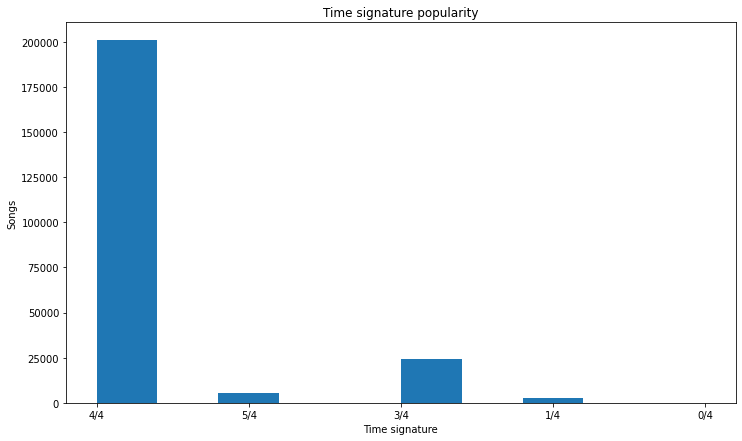

In [3]:
plt.hist(df['time_signature'])
plt.title('Time signature popularity')
plt.xlabel('Time signature')
plt.ylabel('Songs')
plt.show()

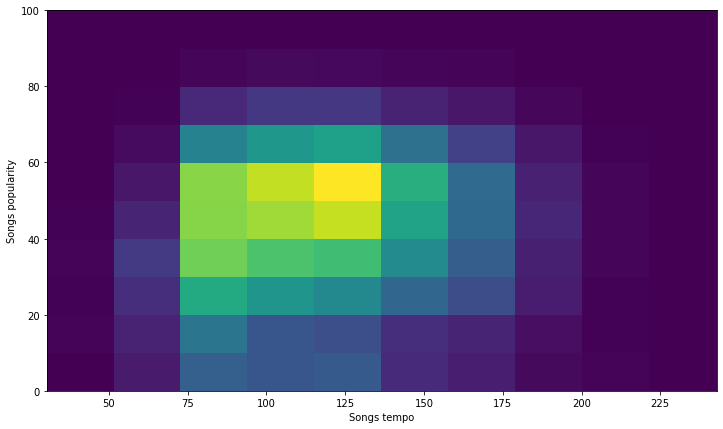

In [4]:
plt.hist2d(df['tempo'],
           df['popularity'])
plt.xlabel('Songs tempo')
plt.ylabel('Songs popularity')
plt.show()

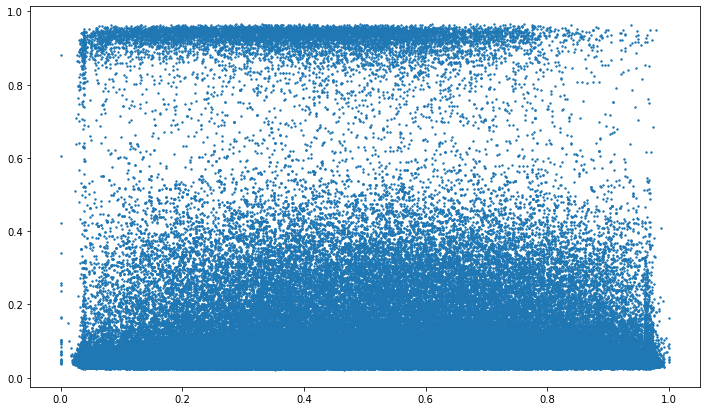

In [5]:
plt.scatter(df['valence'], 
            df['speechiness'],
           s=2)
plt.show()

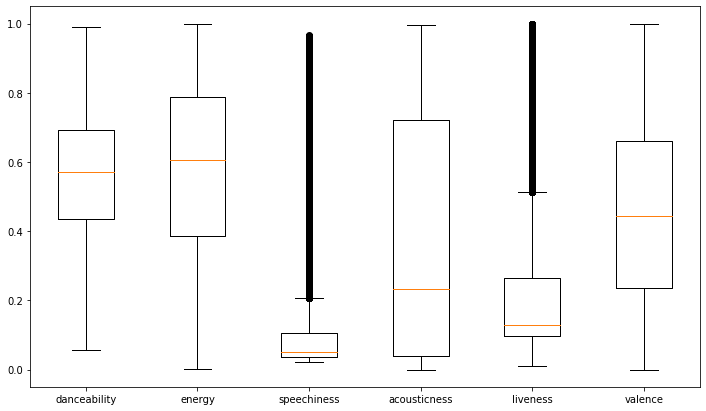

In [7]:
song_features = [ 
    'danceability', 
    'energy', 
    'speechiness',
    'acousticness', 
    'liveness',
    'valence'
]
dff = df[song_features]

plt.boxplot(dff, labels=dff.columns)
plt.show()

In [30]:
def lambda_of(f):
    return lambda x: f(x['acousticness'],
                       x['danceability'],
                       x['energy'],
                       x['instrumentalness'],
                       x['liveness'],
                       x['speechiness'],
                       x['valence'])

1 - (df.apply(lambda_of(max), axis=1) - df.apply(lambda_of(min), axis=1))

0         0.090000
1         0.184000
2         0.048000
3         0.297000
4         0.095600
            ...   
232720    0.041840
232721    0.031880
232722    0.099000
232723    0.255000
232724    0.242049
Length: 232725, dtype: float64

# 2. Интерполяция кривой

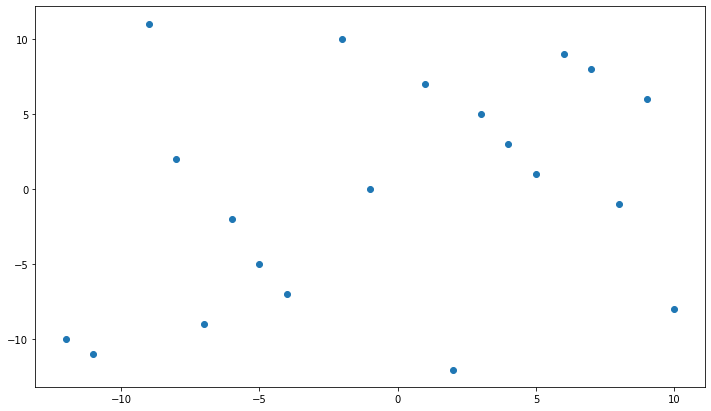

In [43]:
import random

x = random.sample(range(-12, 12), 20)
y = random.sample(range(-12, 12), 20)
plt.scatter(x, y)
plt.show()

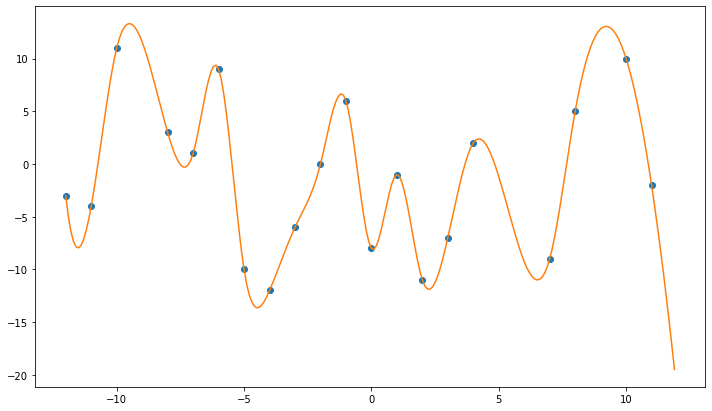

In [28]:
import scipy as sc
import scipy.interpolate
import numpy as np

f = sc.interpolate.interp1d(x, y, kind = 'cubic', fill_value = 'extrapolate')
x1 = np.arange(-12, 12, 0.1)
y1 = f(x1)
plt.plot(x, y, 'o', x1, y1, '-')
plt.show()

(-15.0, 15.0)

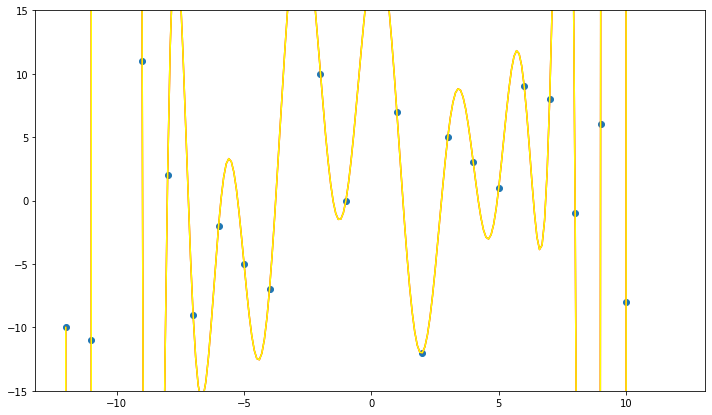

In [50]:
def lagrange(x, y):
    n = len(x)
    def fp(xq):
        yq = 0.0
        for i in range(n):
            ln = 1.0
            ld = 1.0
            for j in range(n):
                if j != i:
                    ln *= xq - x[j]
                    ld *= x[i] - x[j]
            yq += y[i] * ln / ld
        return yq
    return fp

plt.plot(x, y, 'o')
y1 = lagrange(x, y)(x1)
plt.plot(x1, y1, color='red')
y1 = sc.interpolate.lagrange(x, y)(x1)
plt.plot(x1, y1, color='yellow')
plt.ylim(-15, 15)

# 3. Быстрая гистограмма

In [81]:
from typing import List, Tuple, Union
import math

def fast_hist(array: List[Union[int, float]], 
              bins: int) -> Tuple[List[int], List[float]]:
    if len(array) == 0 or bins <= 0:
        return ([], [])
    mina = min(array)
    maxa = max(array)
    binw = (maxa - mina) / bins
    cnt = [0] * (bins + 1)
    for i in array:
        cnt[int((i - mina) / binw)] += 1
    cnt[-2] += cnt.pop()
    return (cnt, [i * binw for i in range(bins)])

In [72]:
array = np.random.normal(size=1000)
bins = 77
mina = np.amin(array)
maxa = np.amax(array)
binw = (maxa - mina) / bins

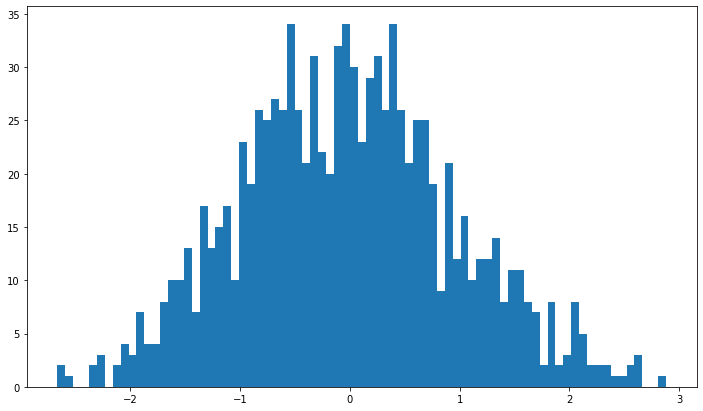

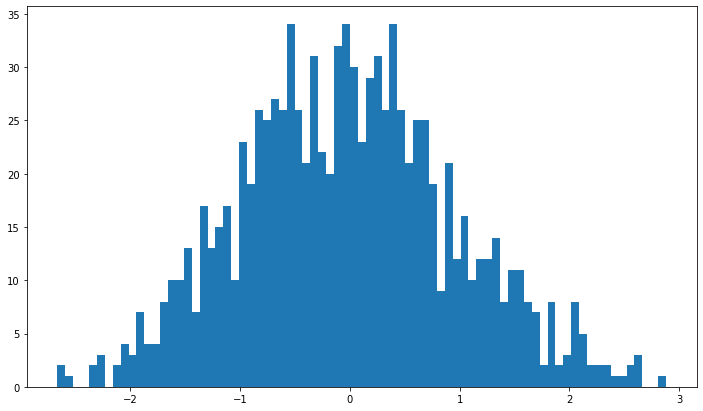

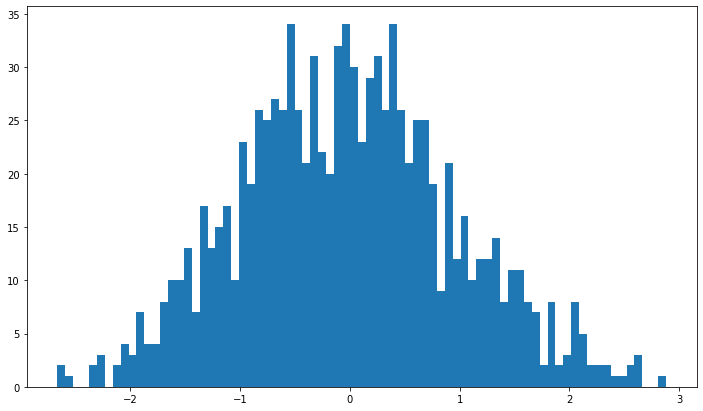

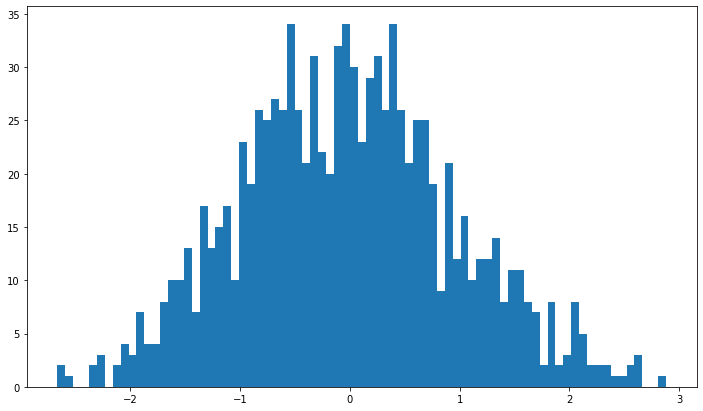

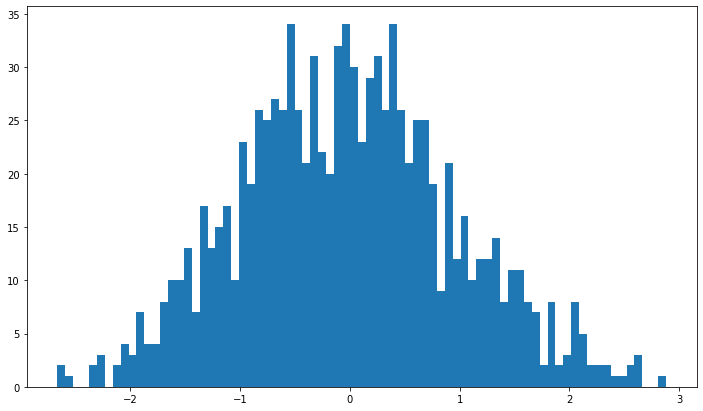

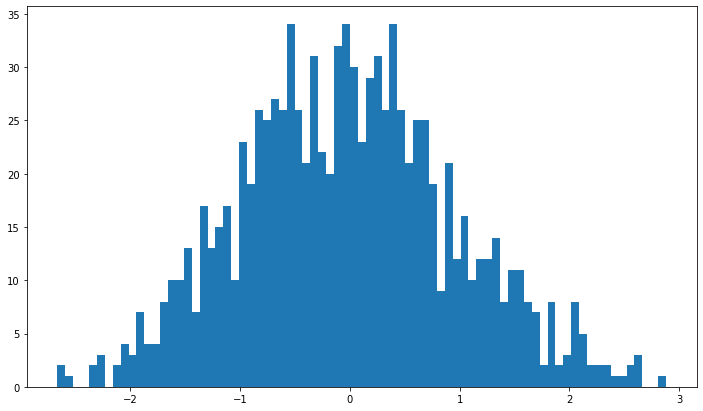

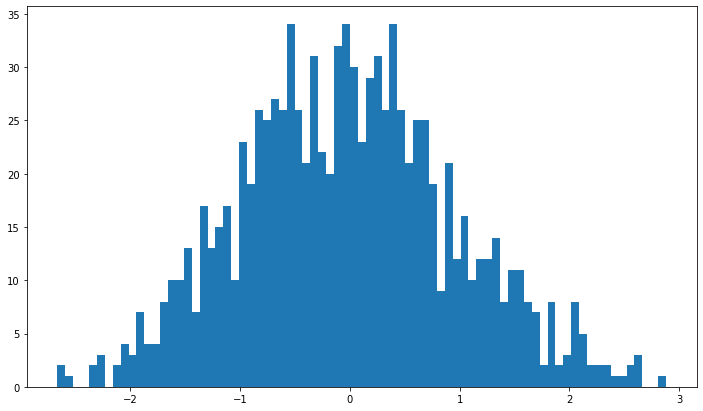

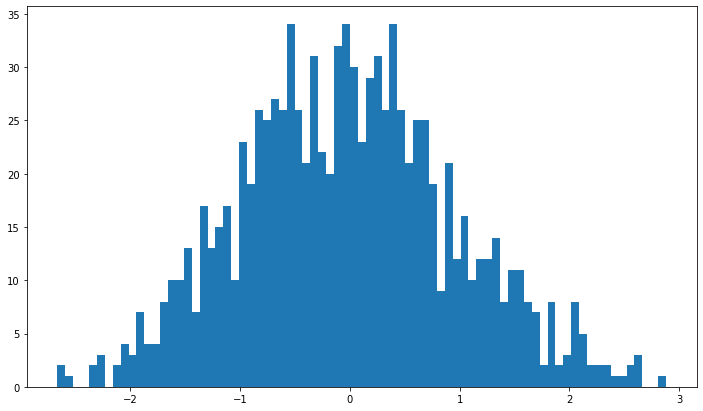

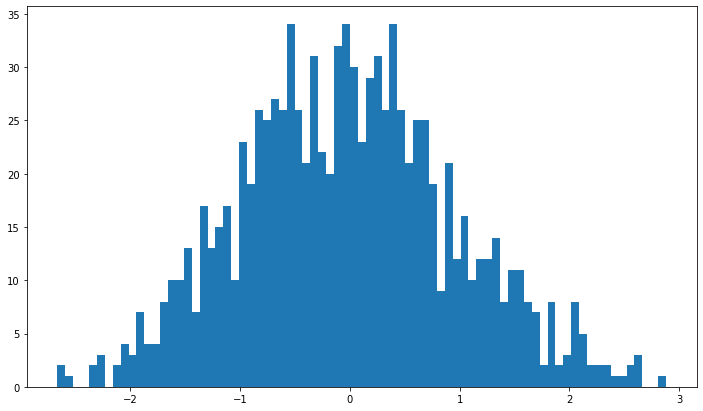

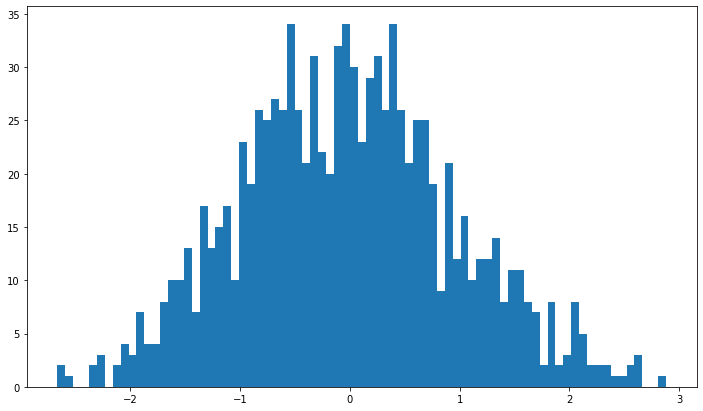

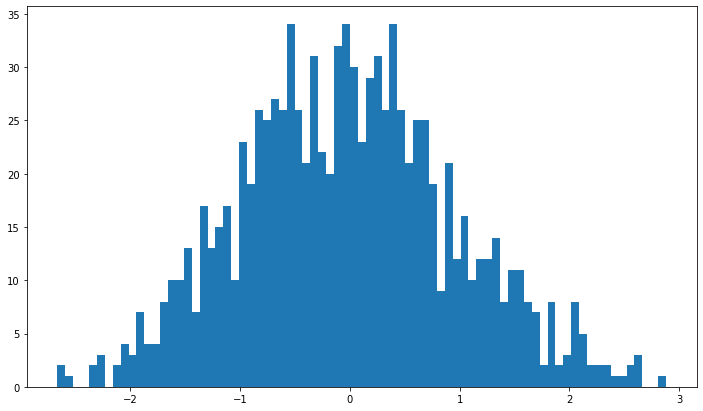

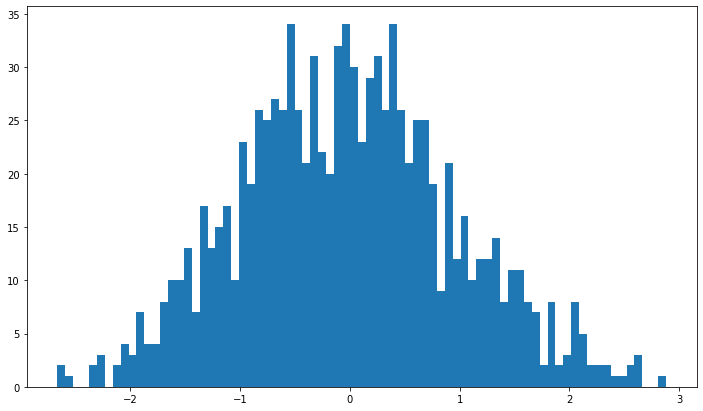

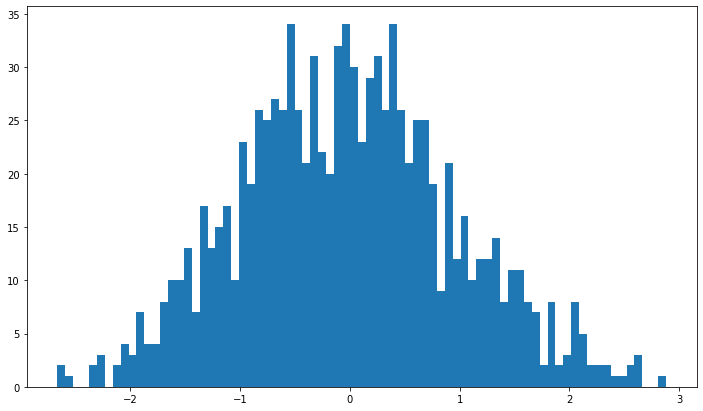

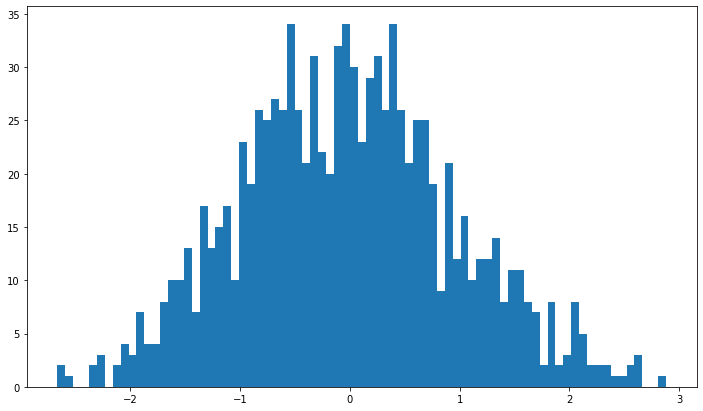

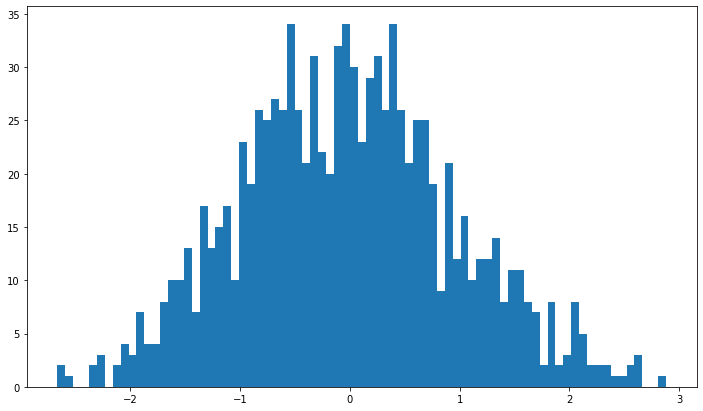

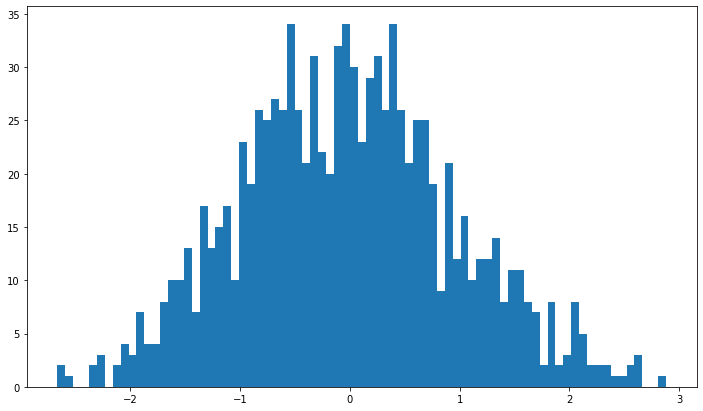

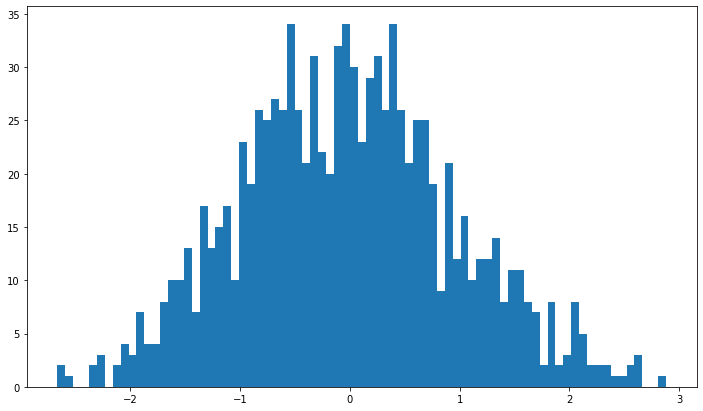

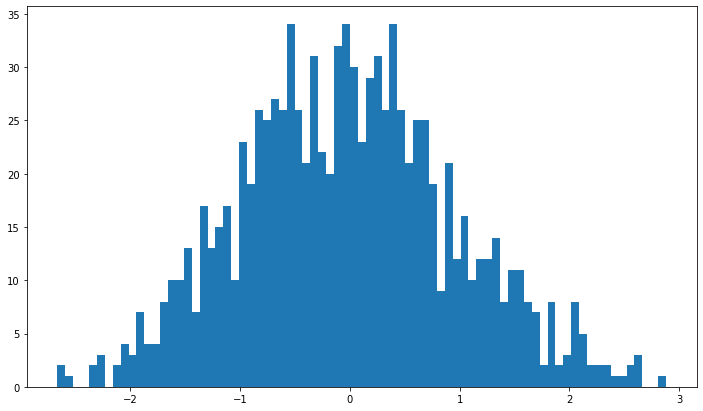

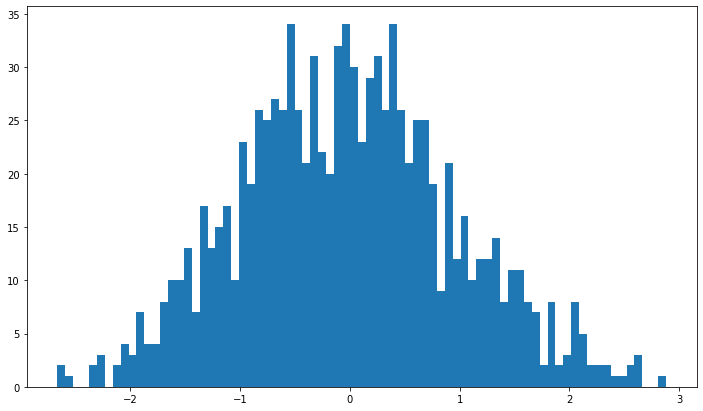

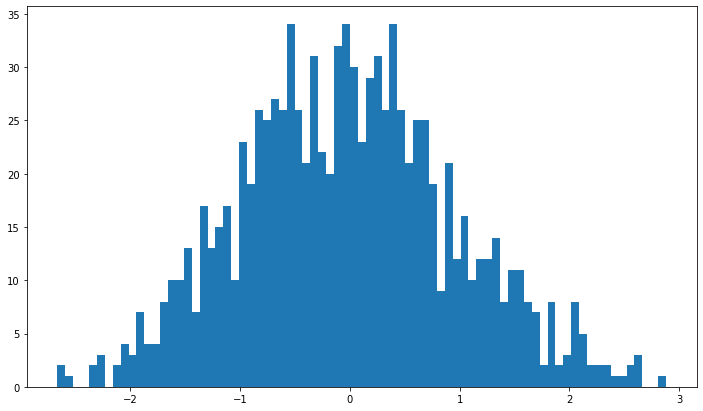

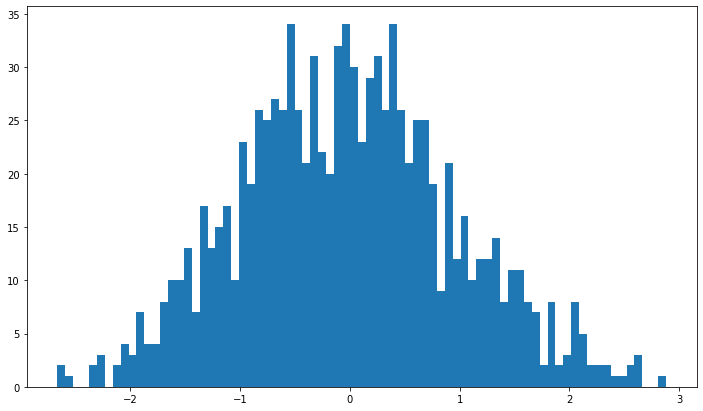

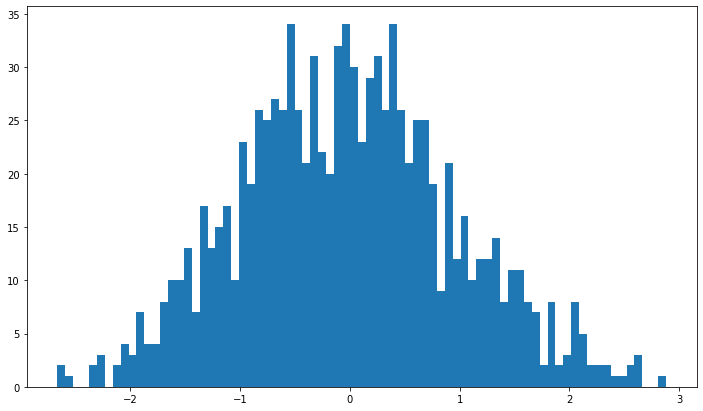

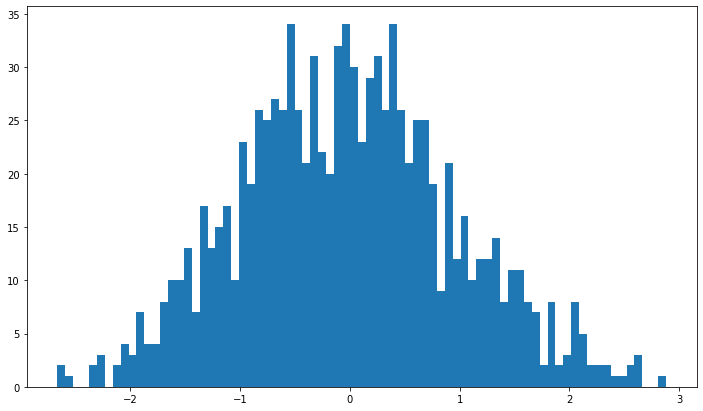

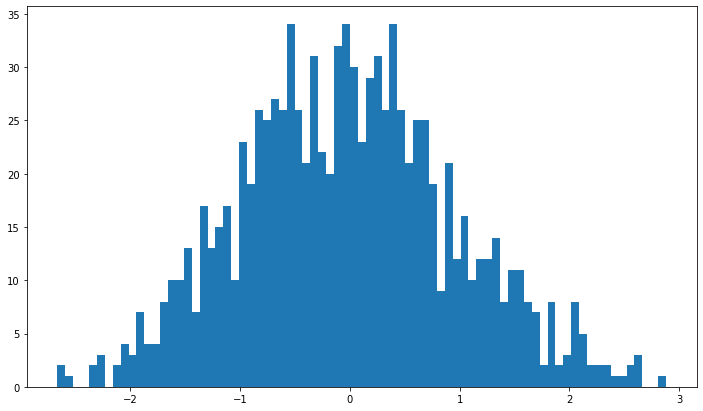

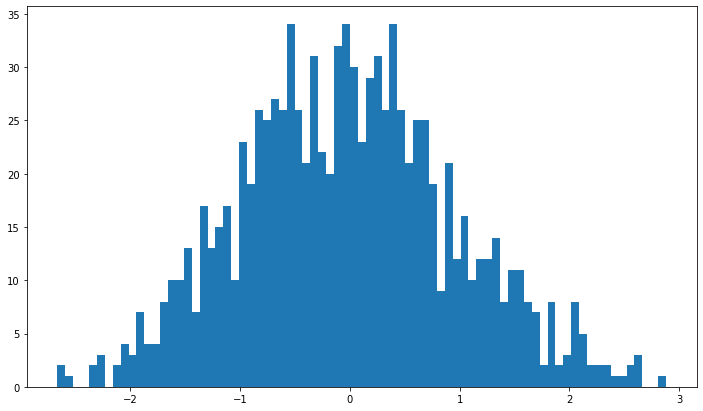

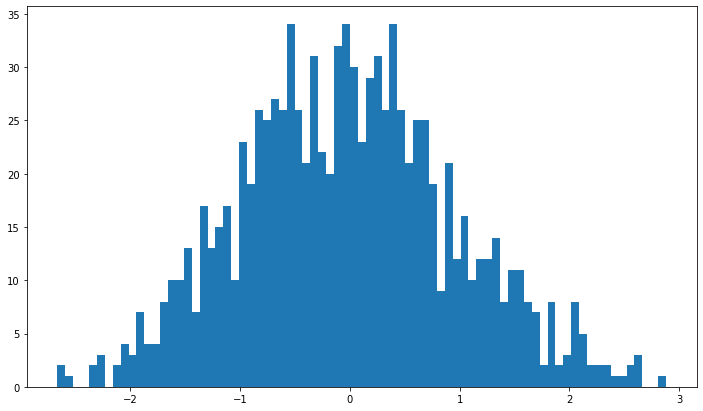

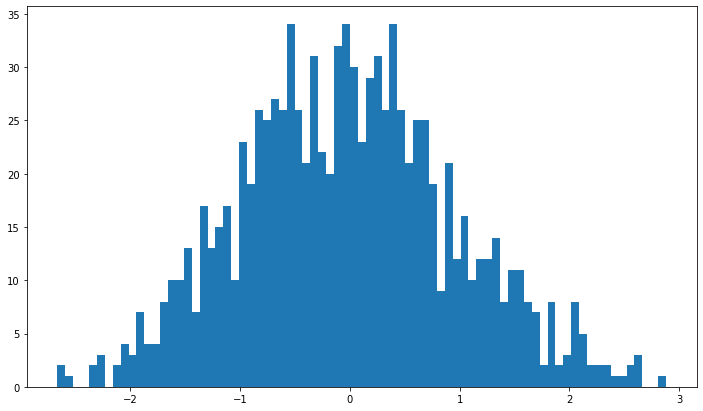

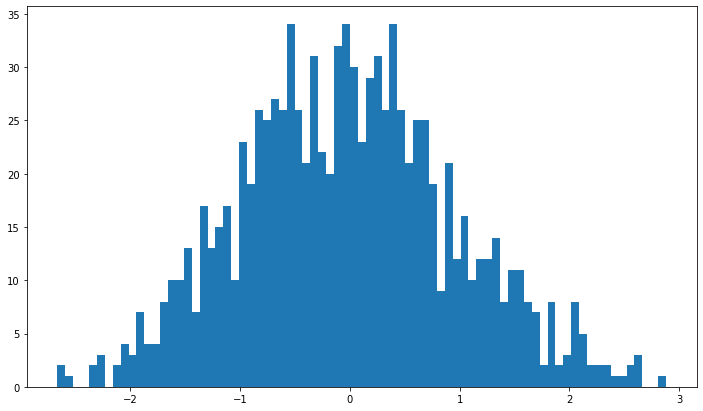

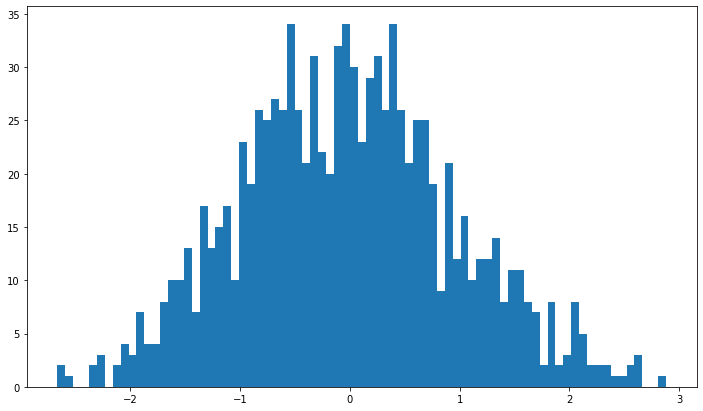

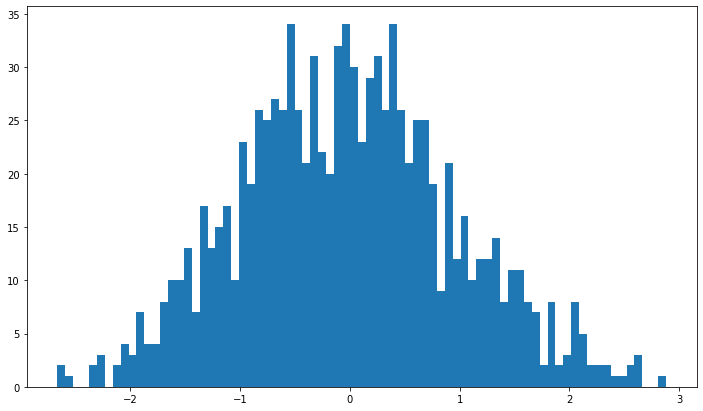

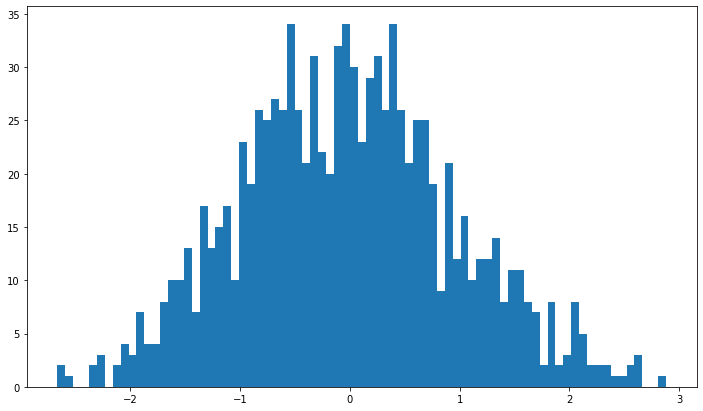

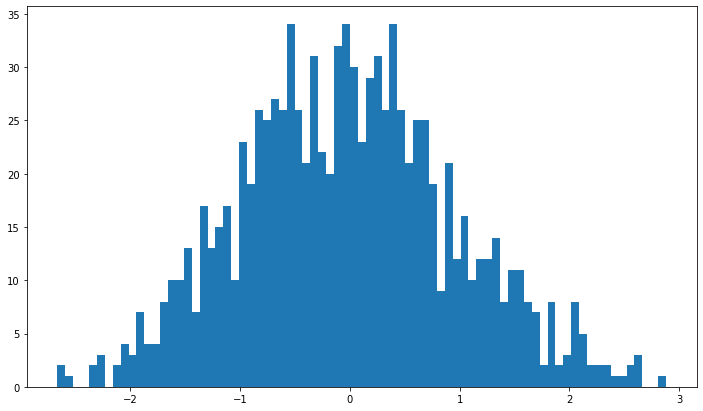

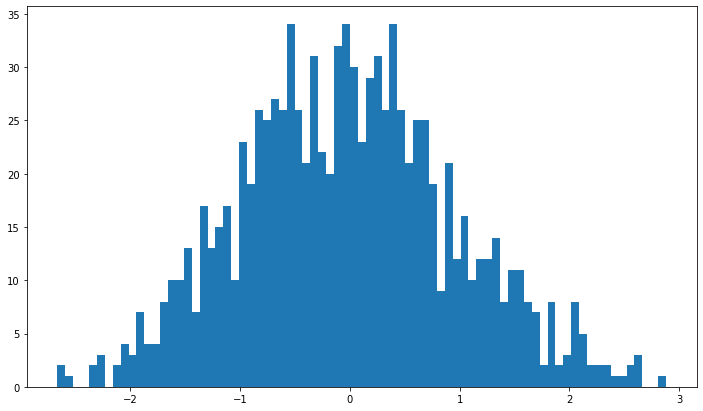

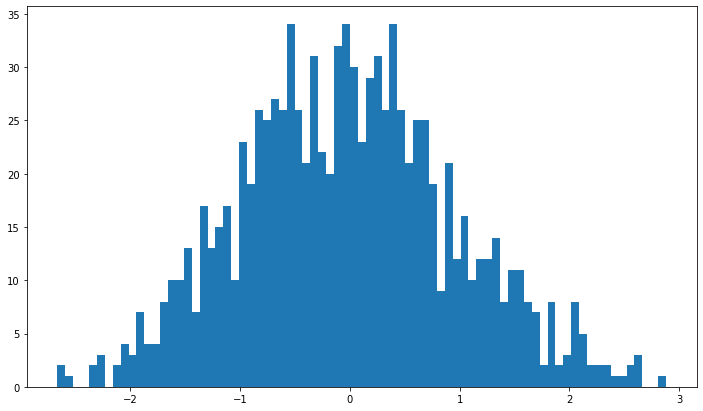

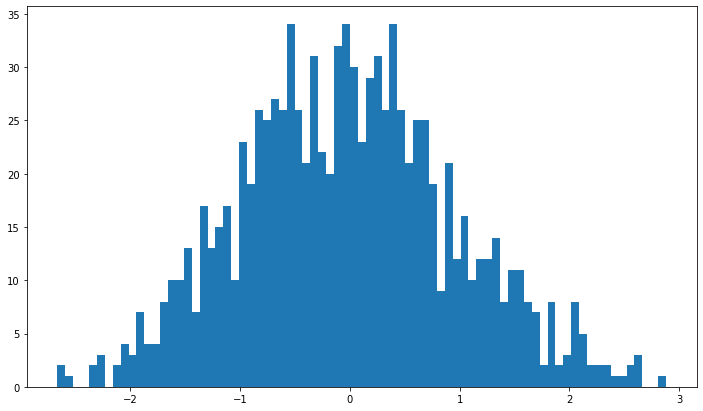

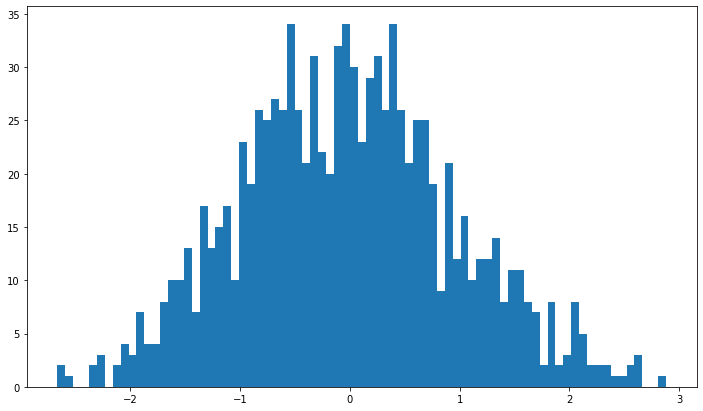

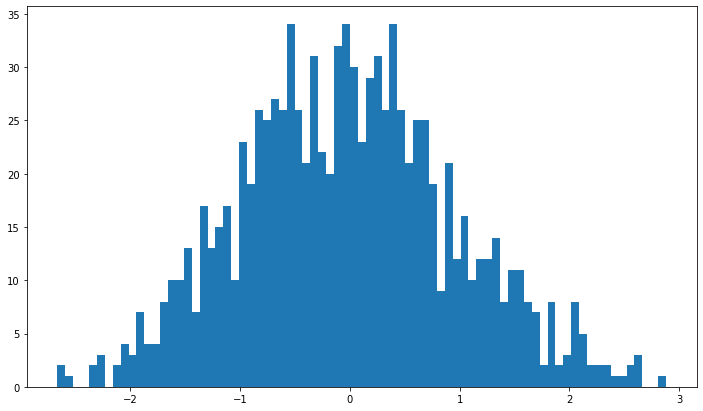

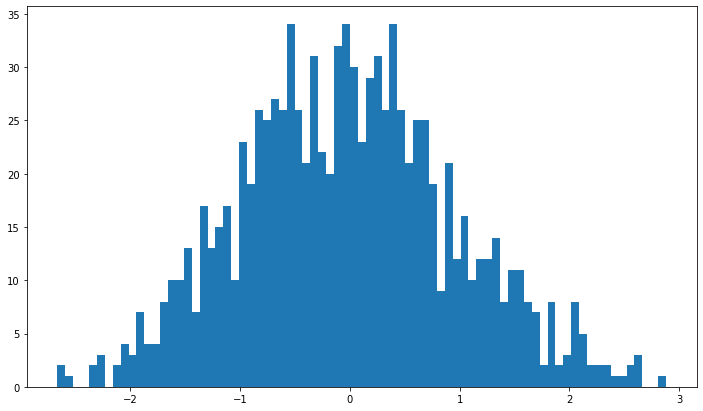

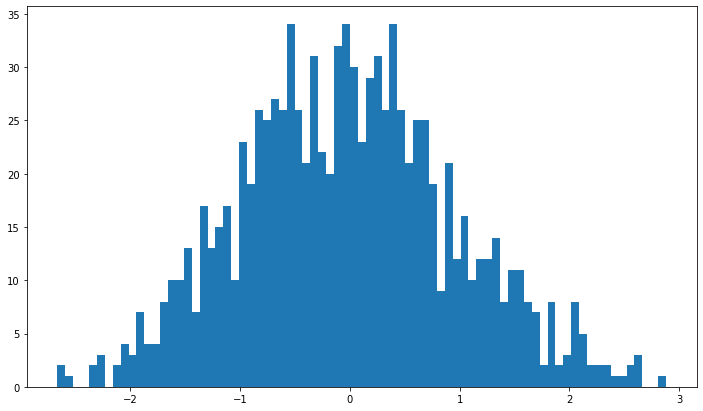

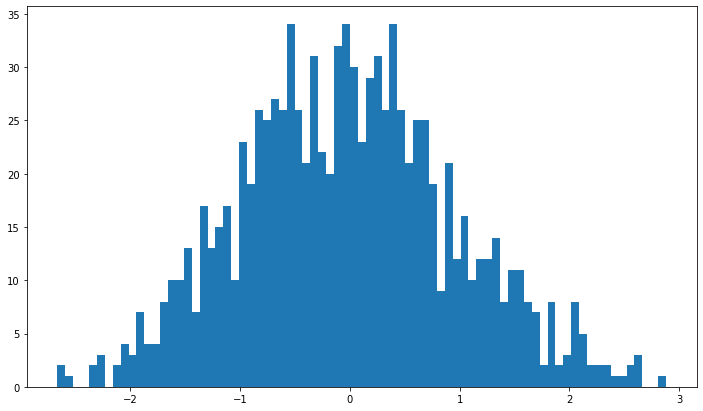

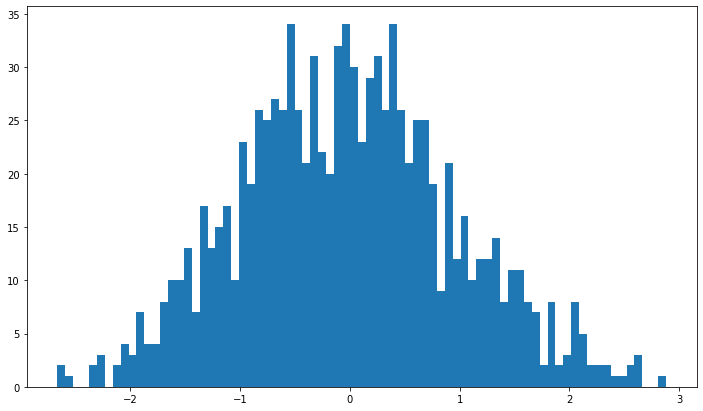

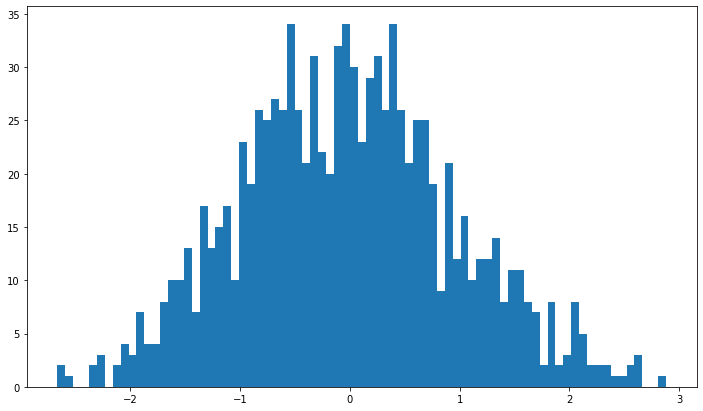

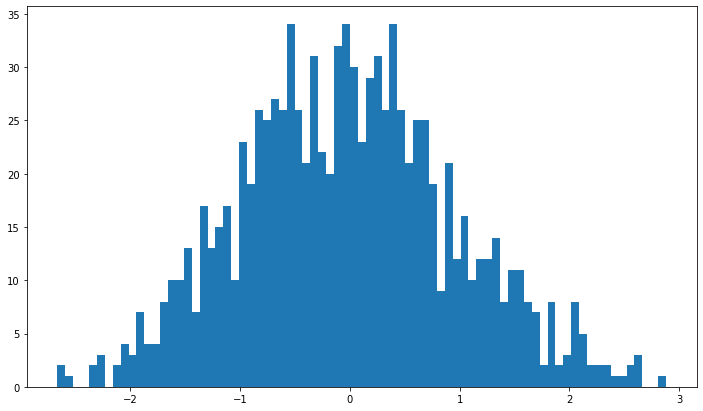

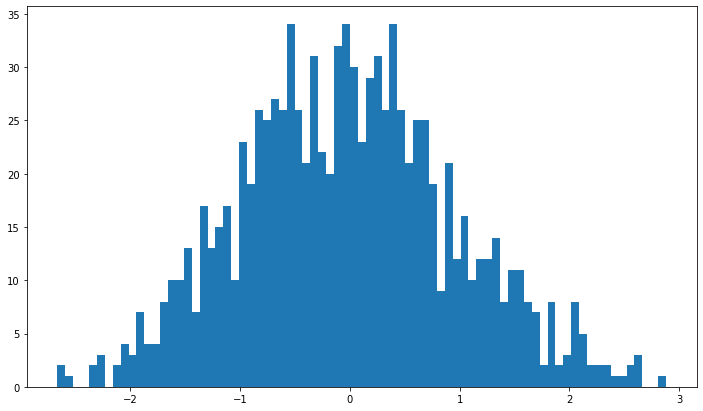

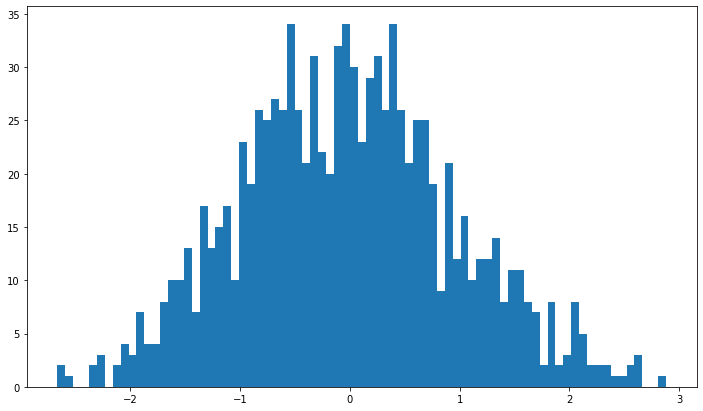

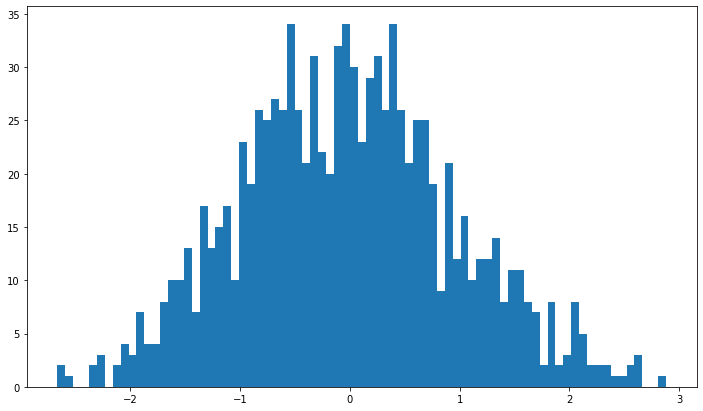

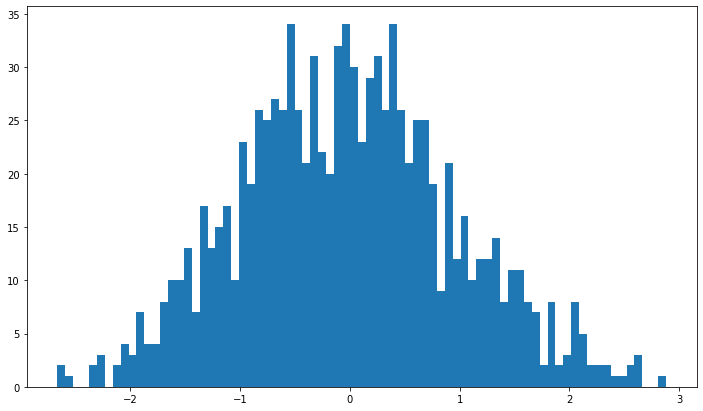

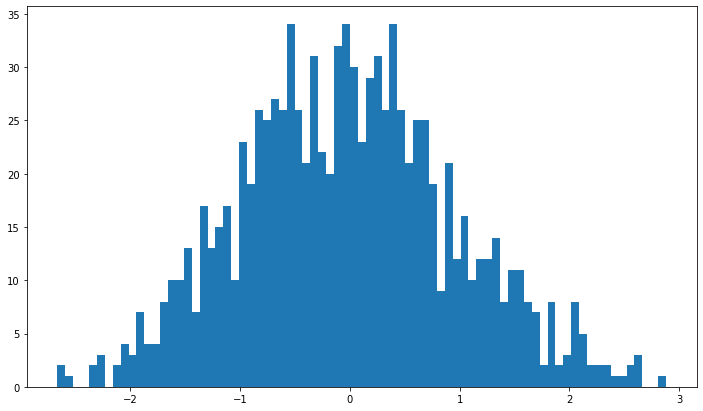

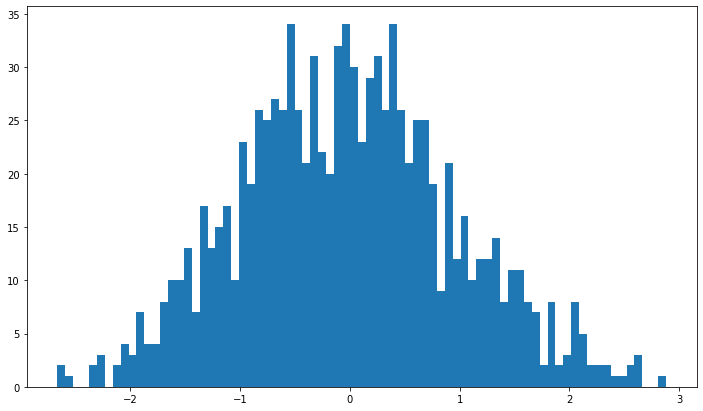

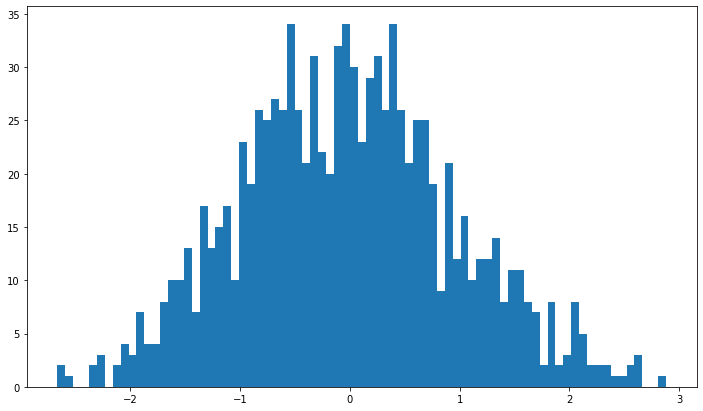

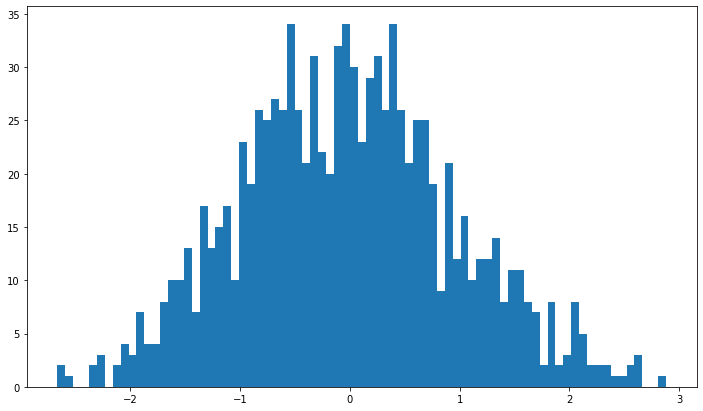

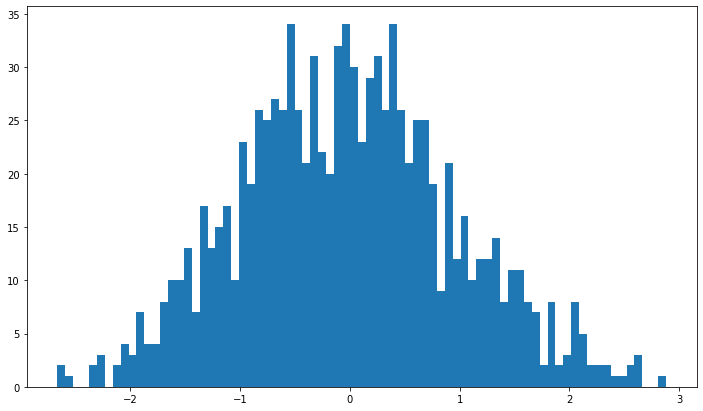

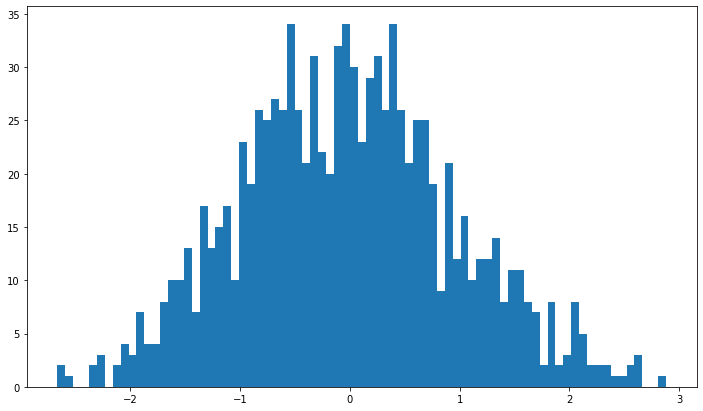

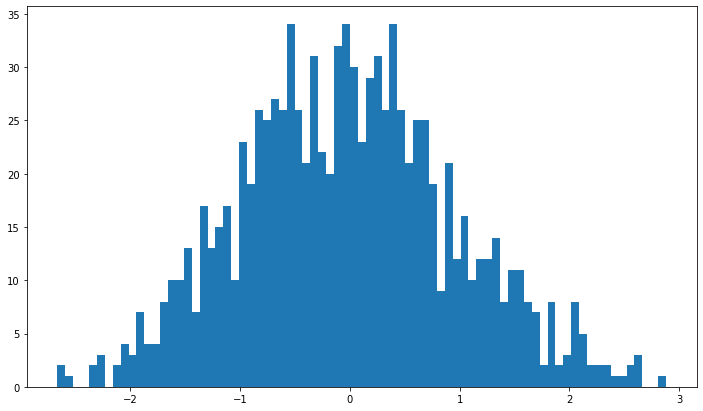

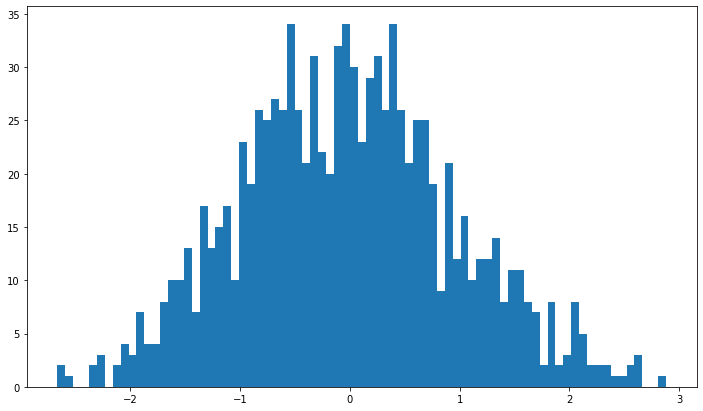

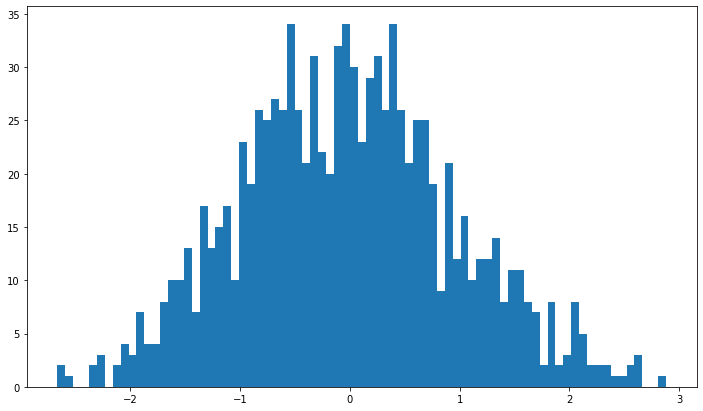

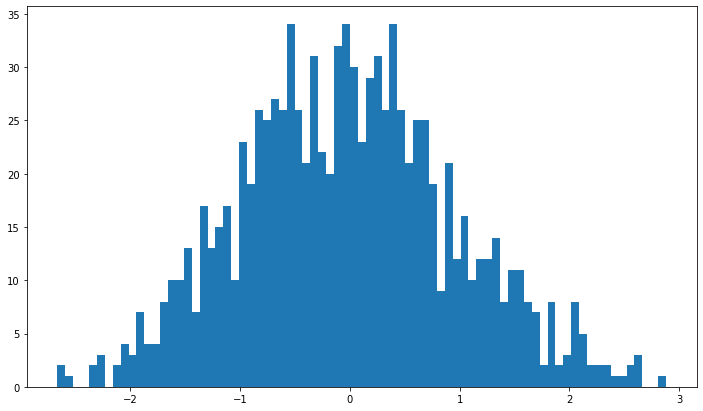

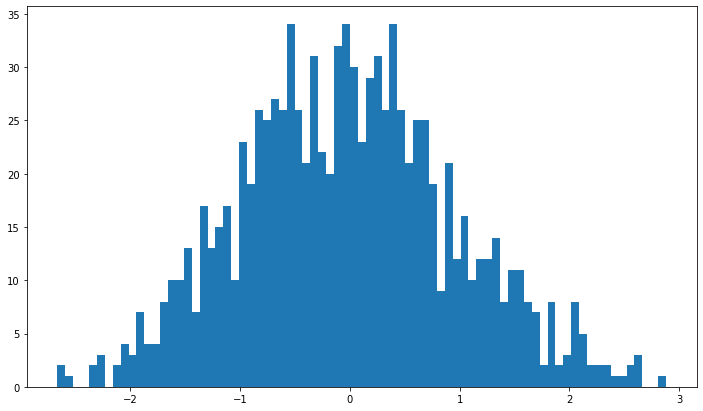

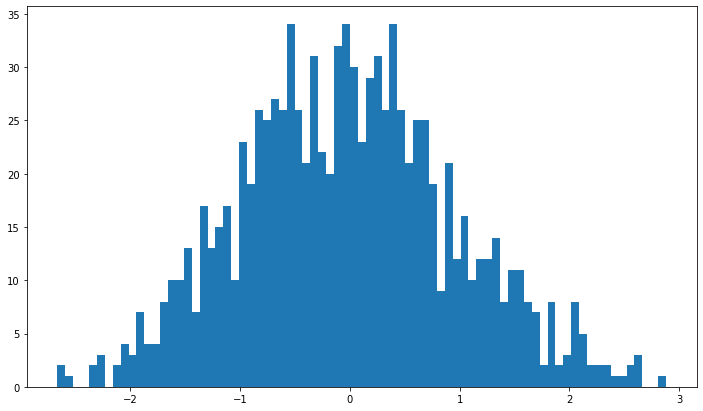

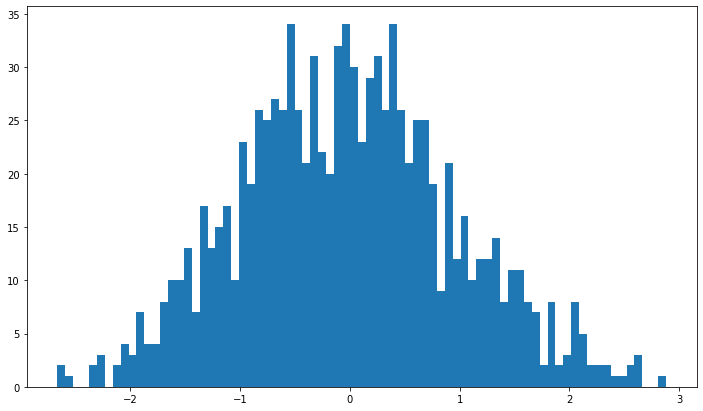

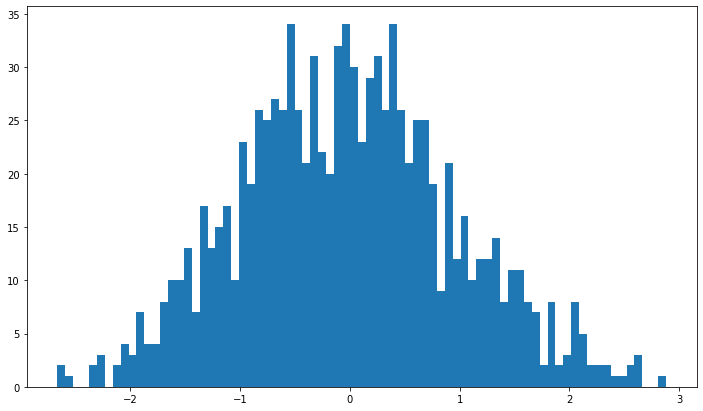

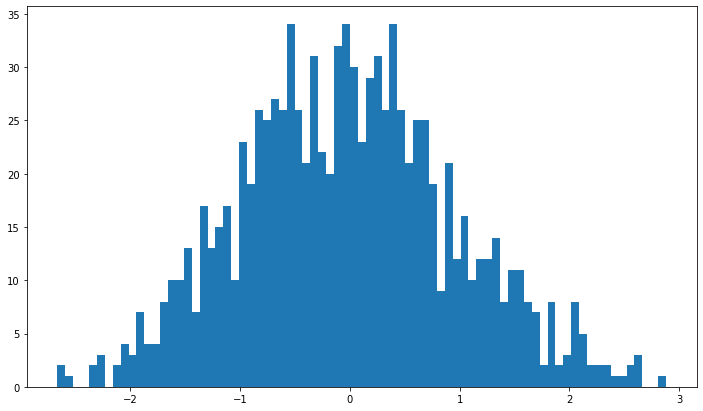

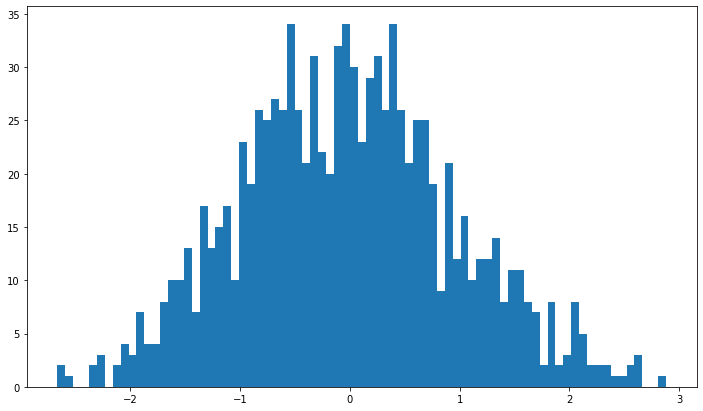

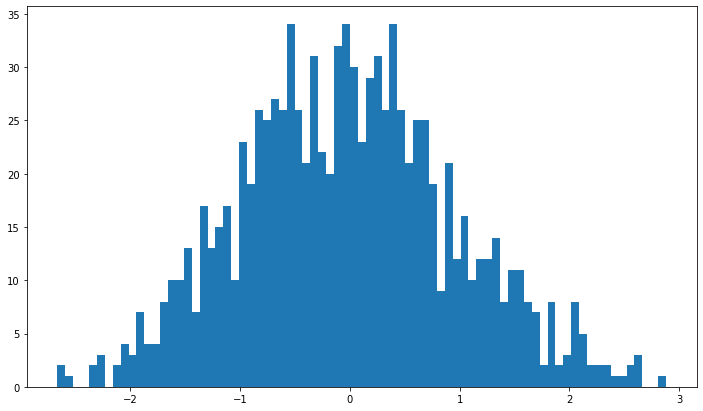

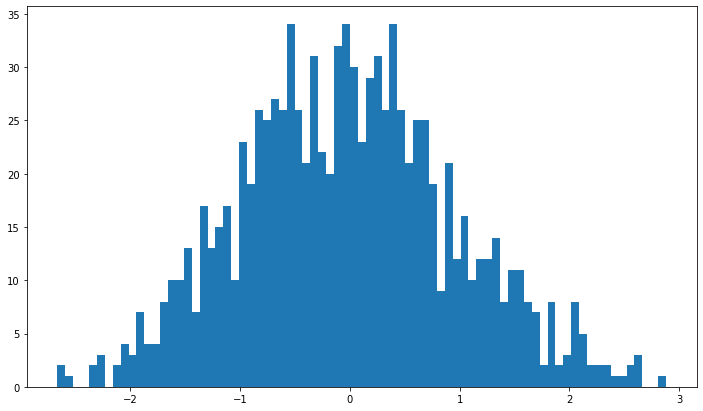

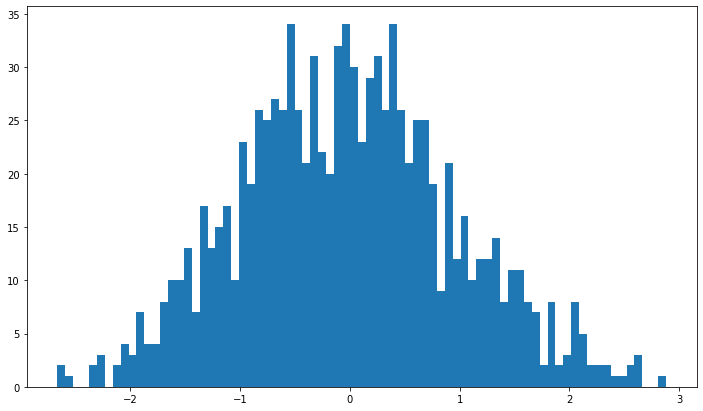

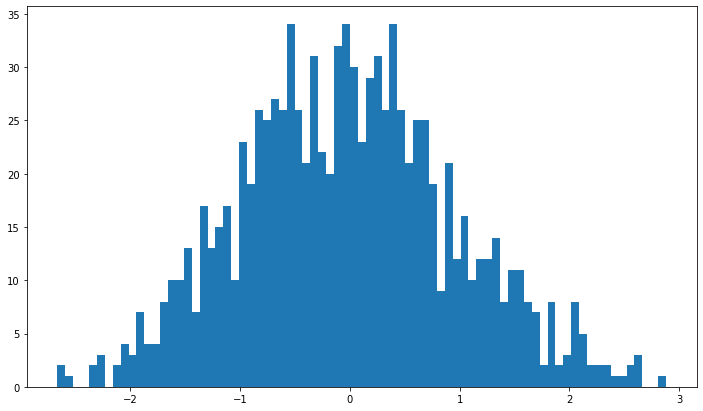

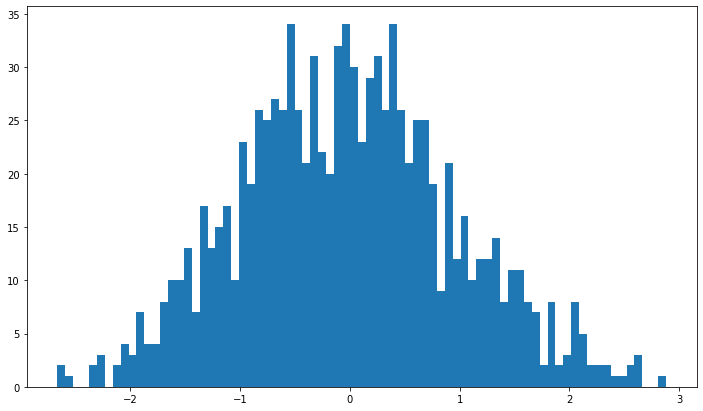

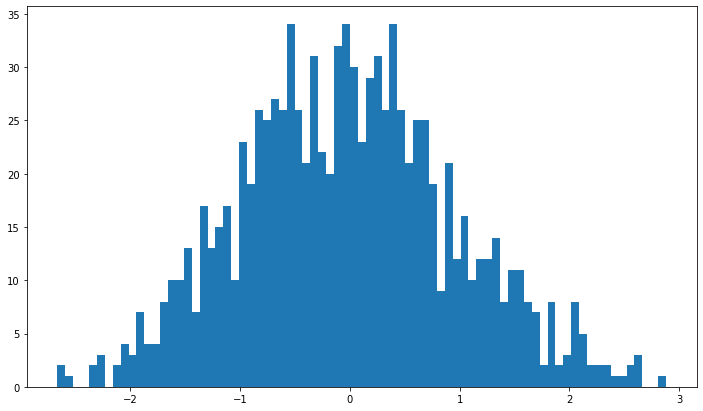

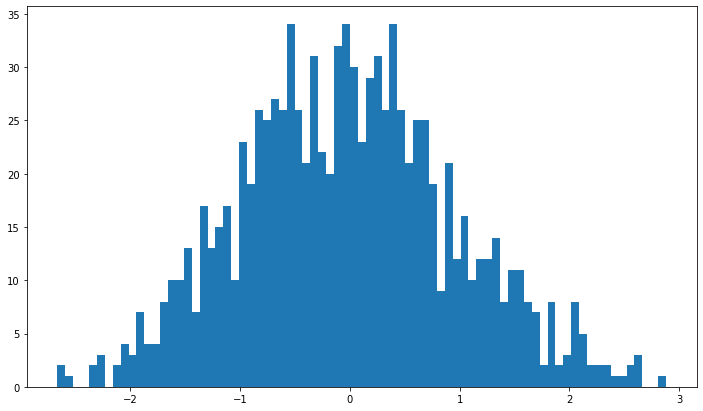

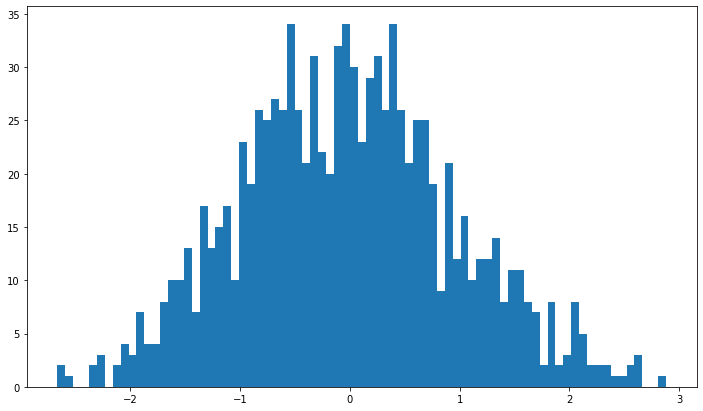

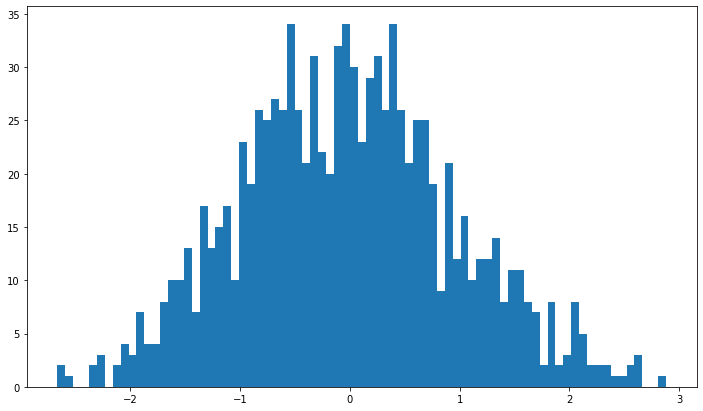

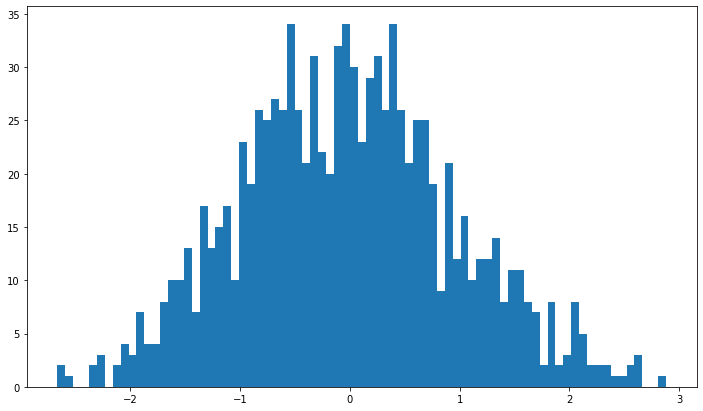

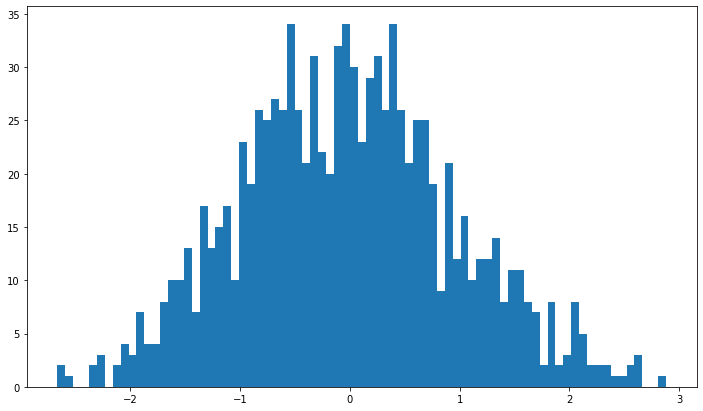

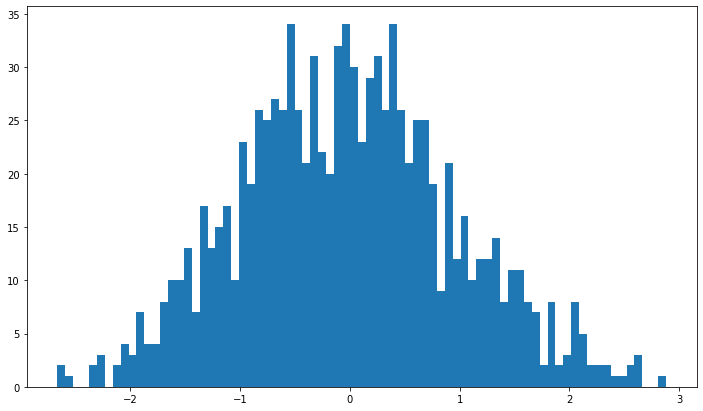

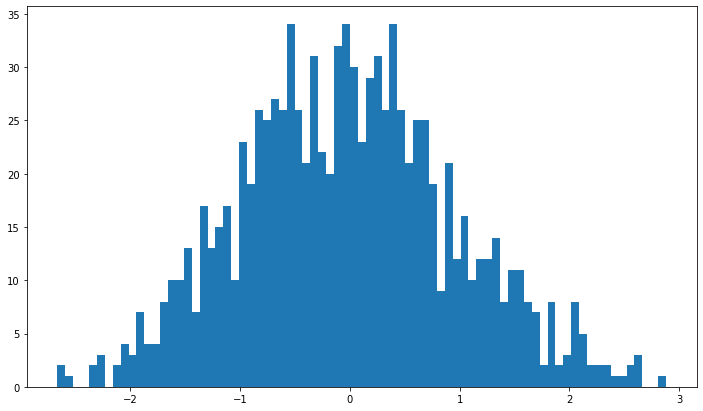

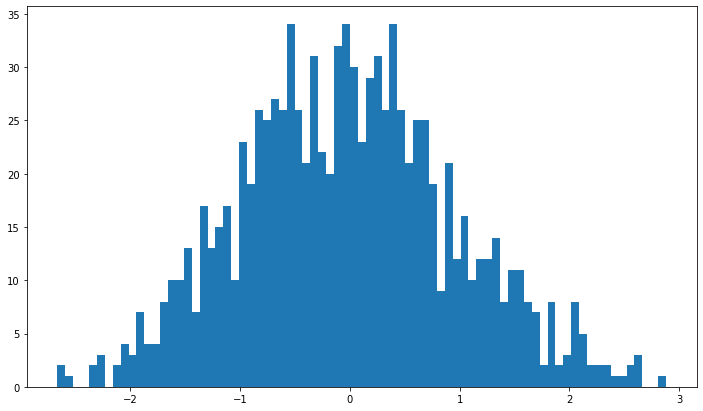

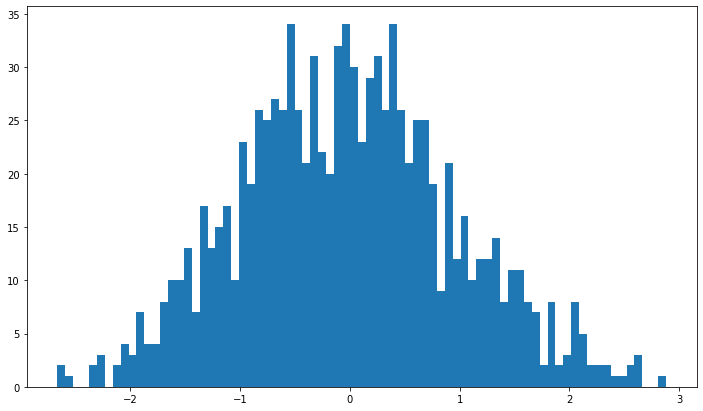

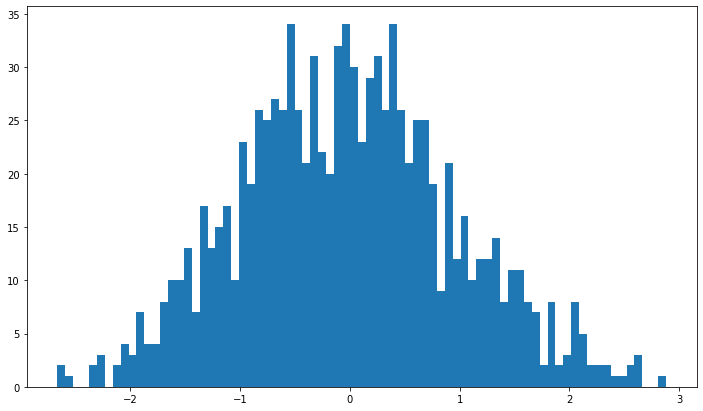

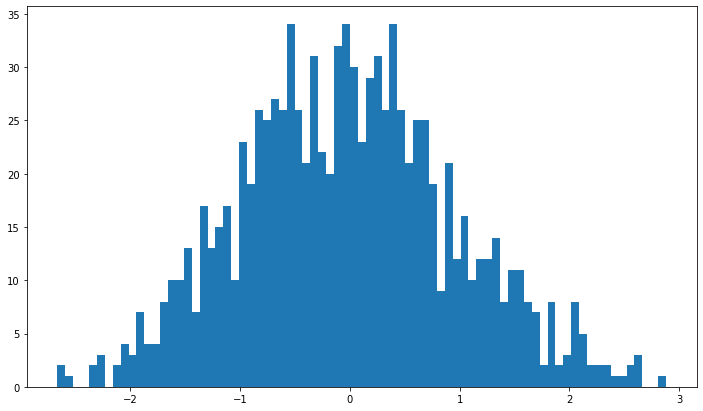

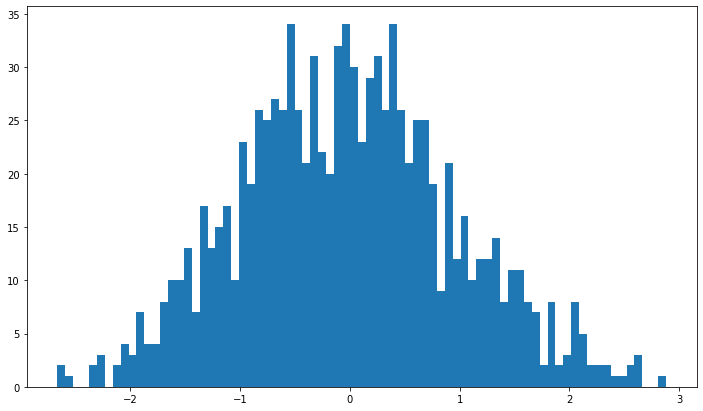

165 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
plt.hist(array, bins=bins)
plt.show()

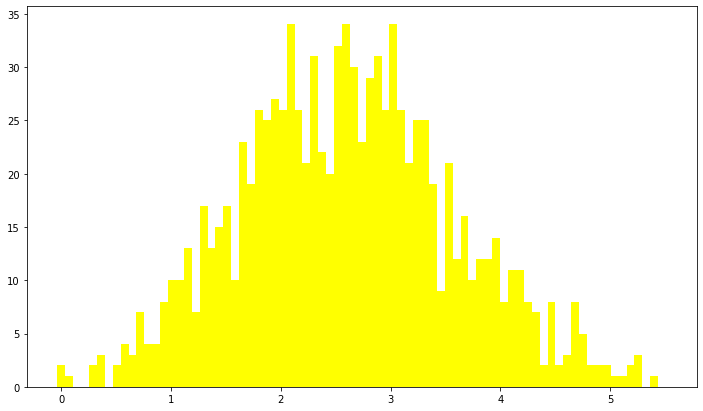

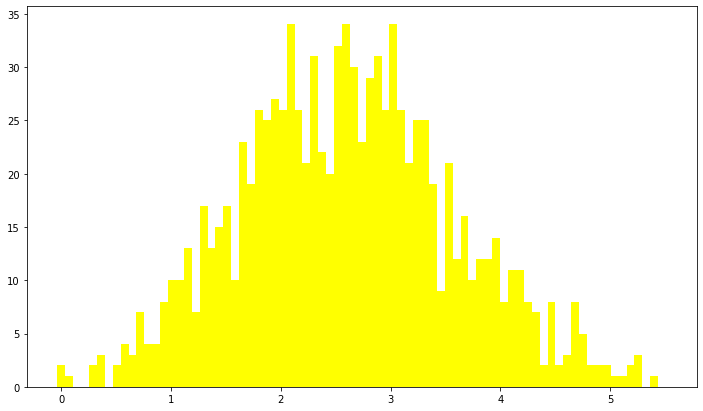

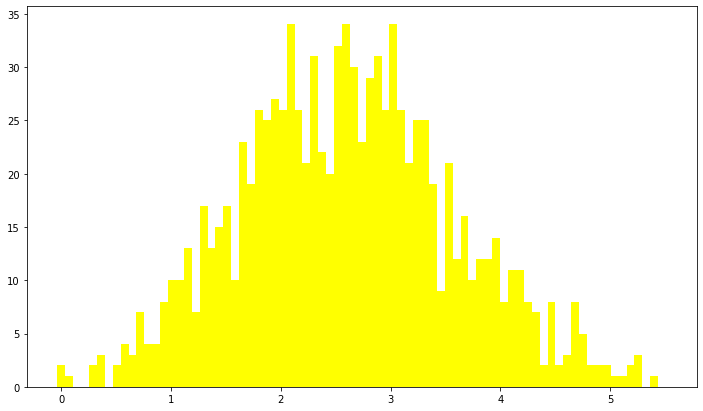

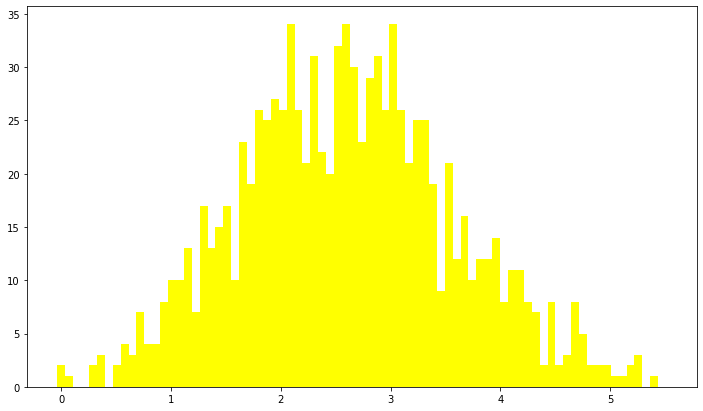

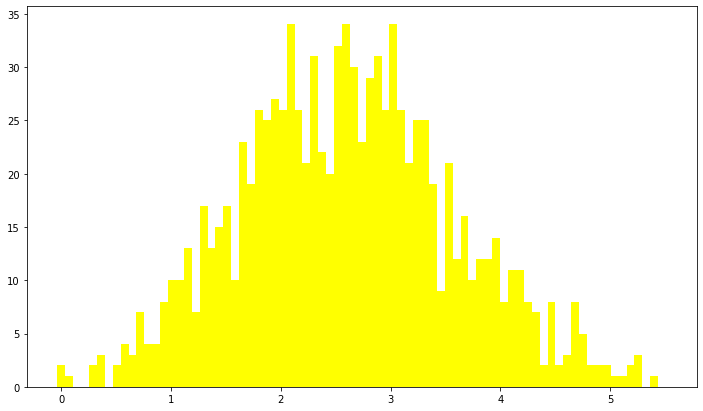

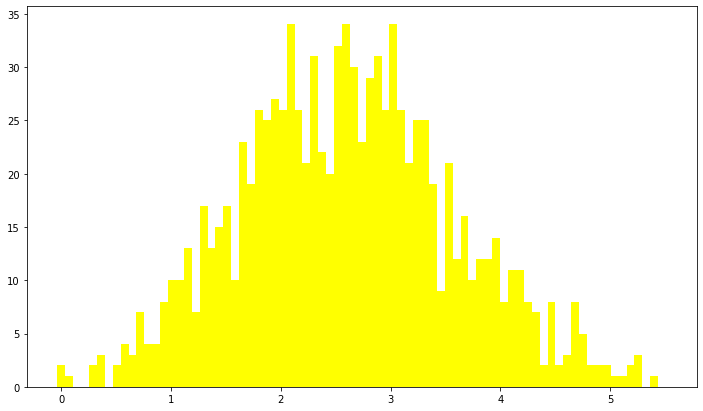

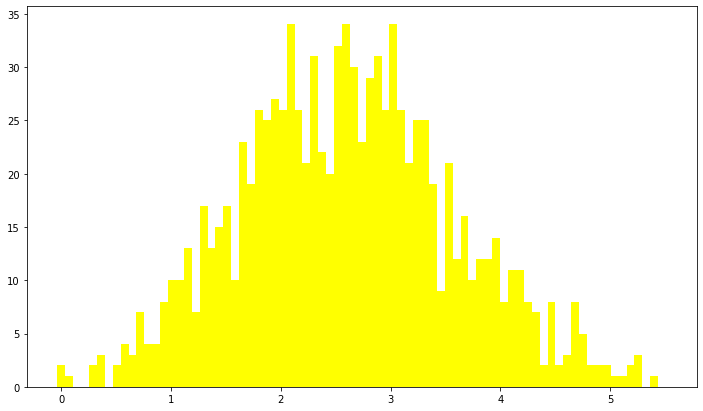

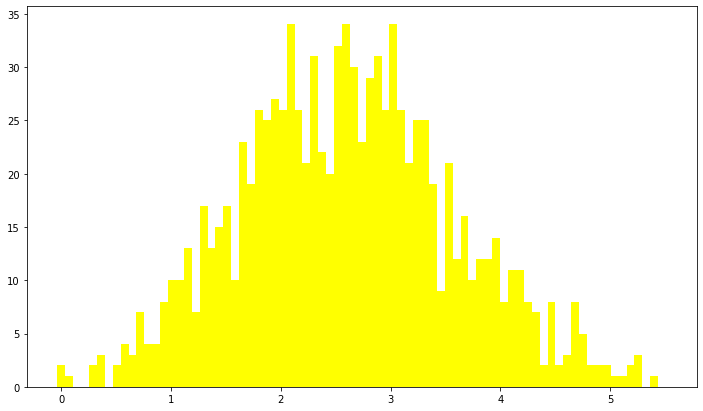

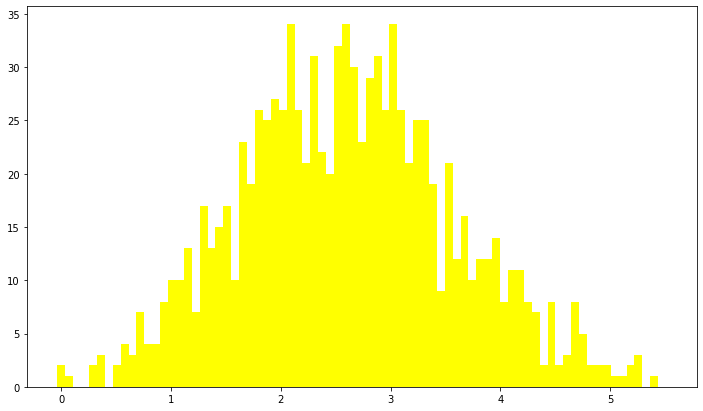

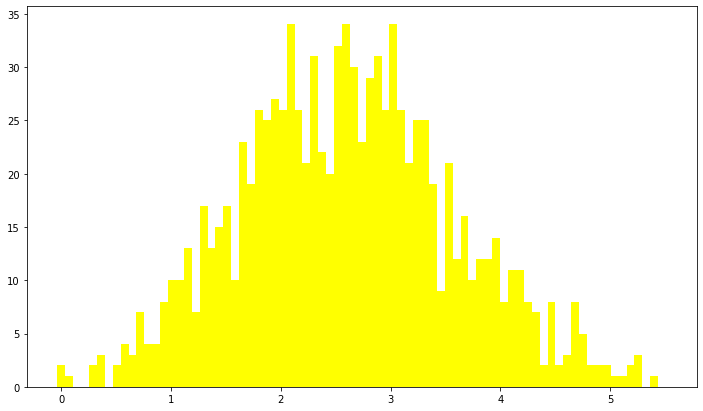

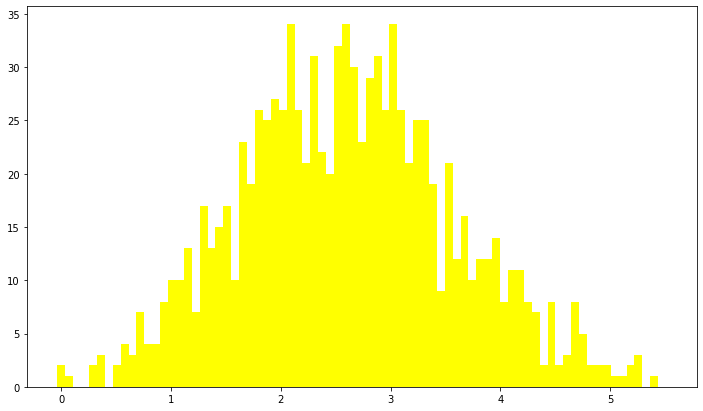

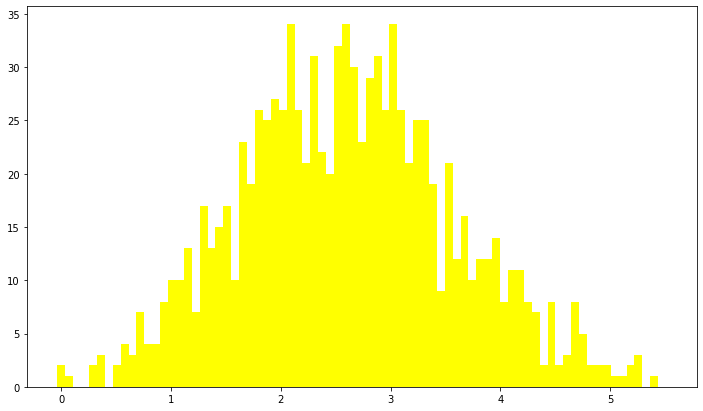

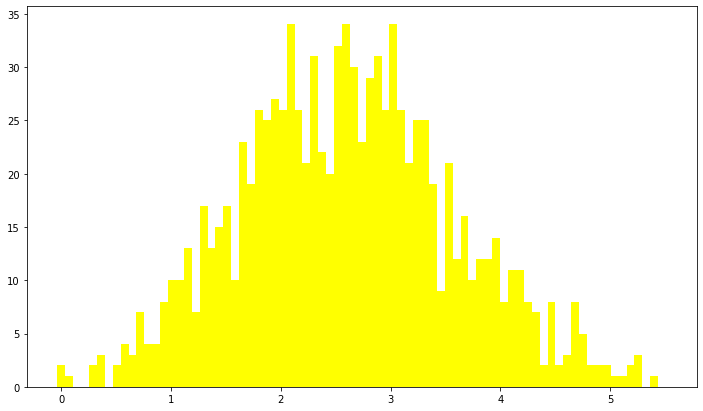

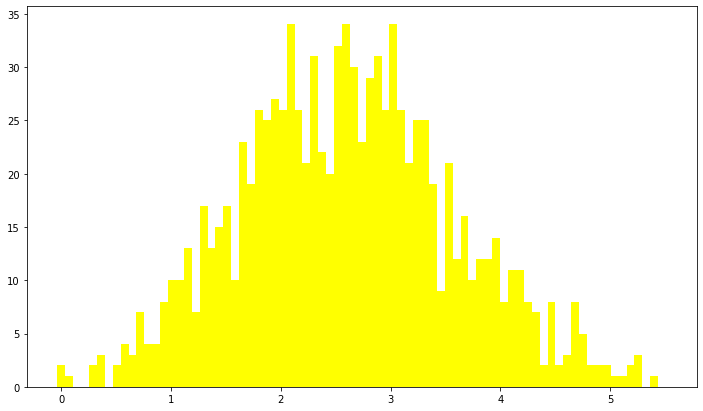

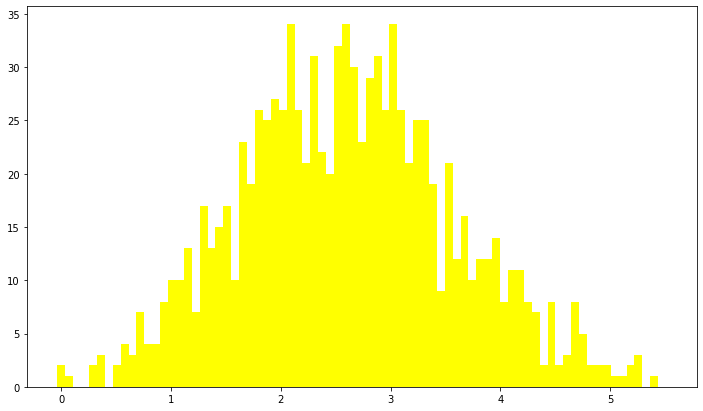

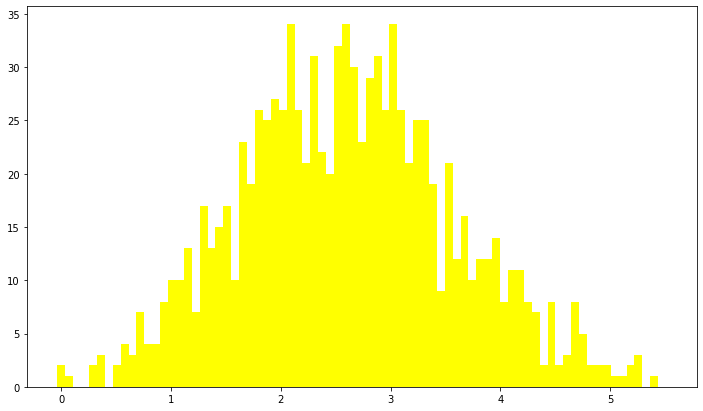

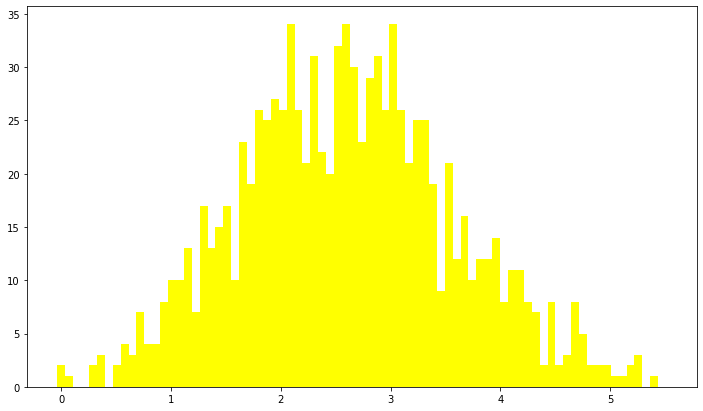

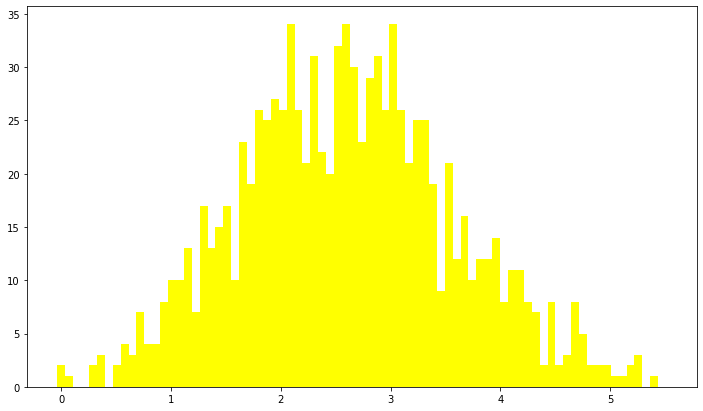

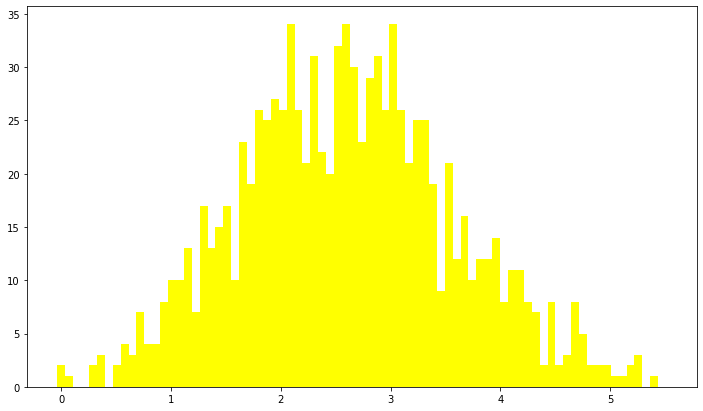

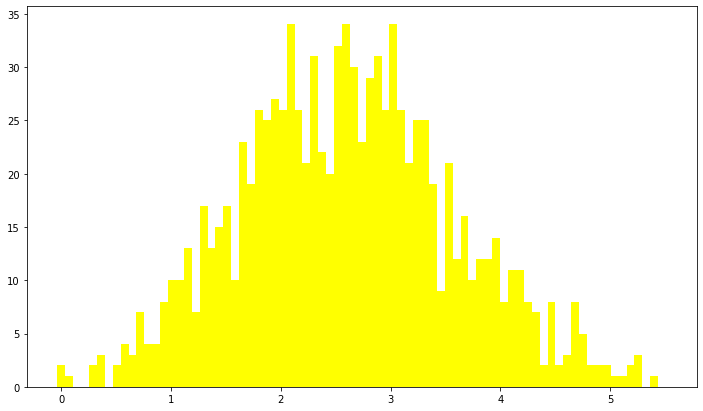

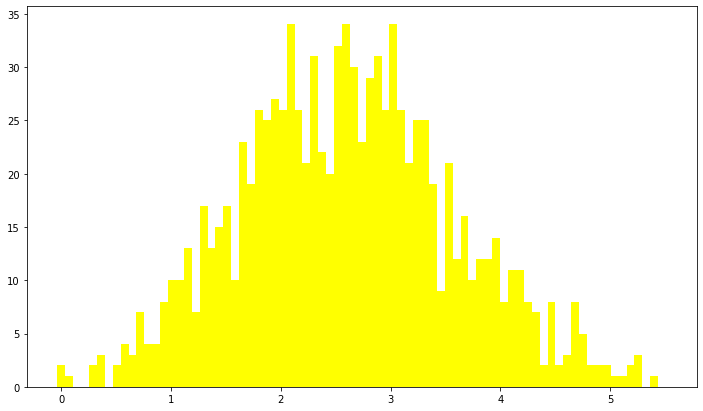

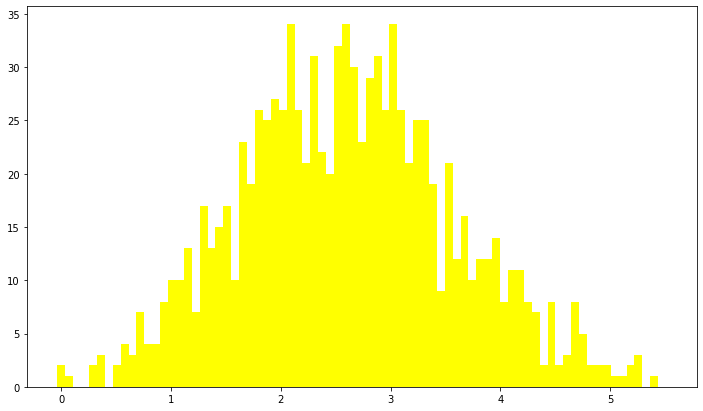

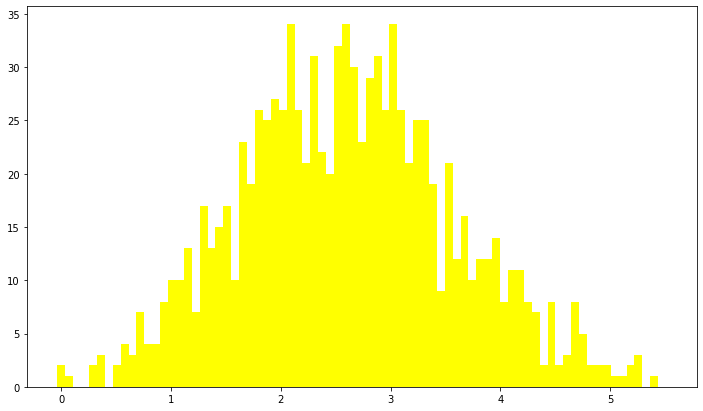

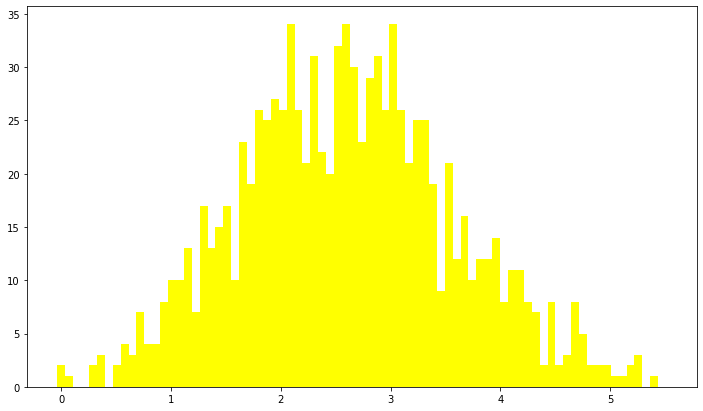

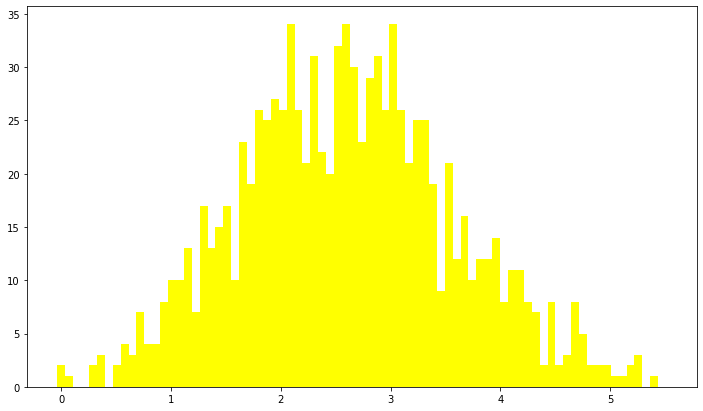

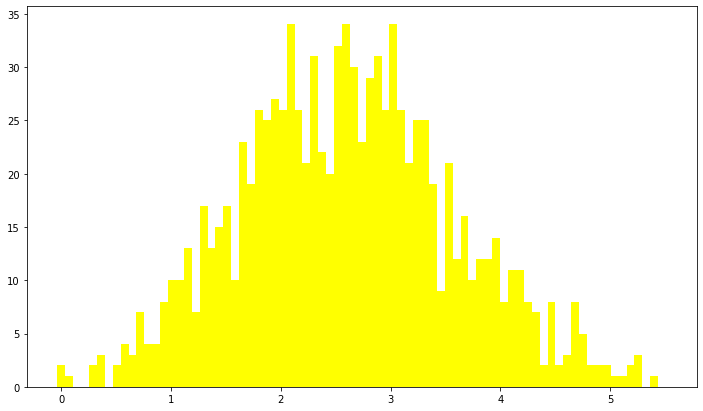

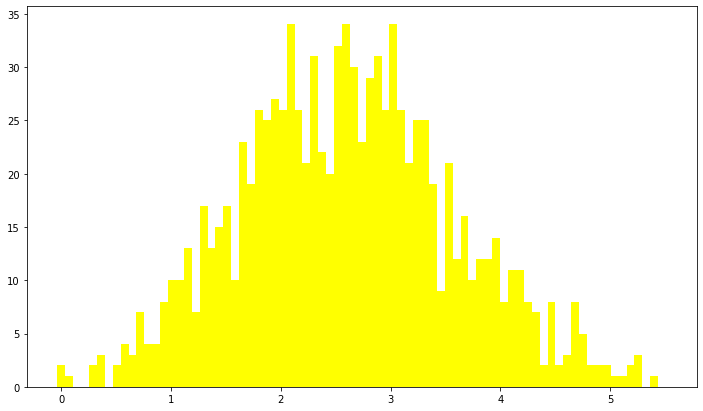

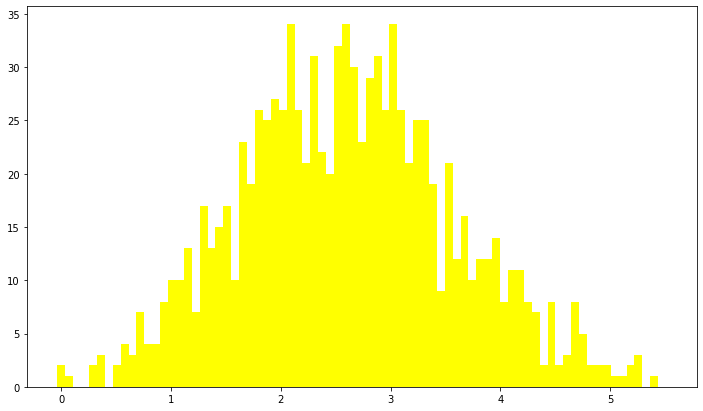

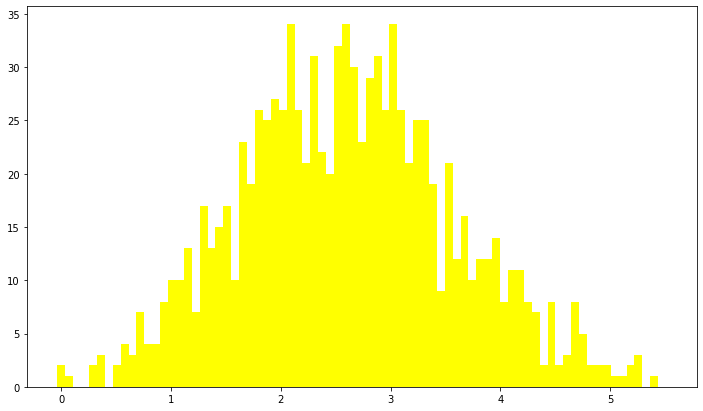

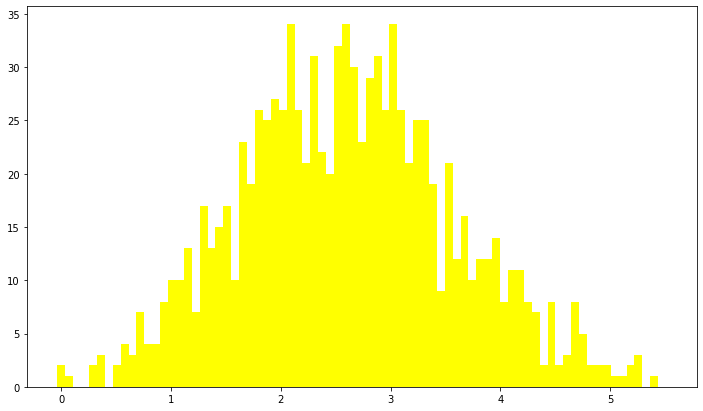

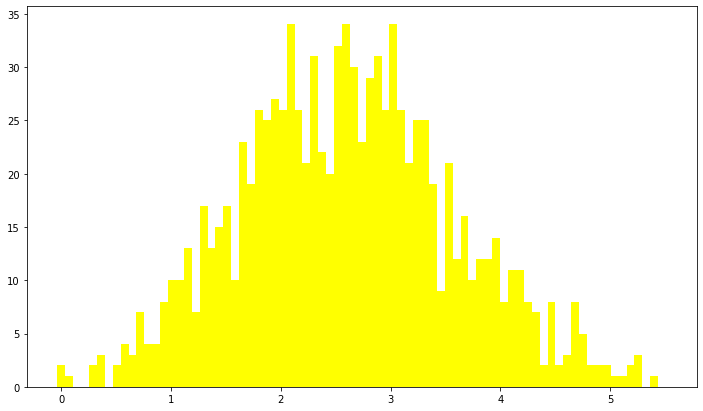

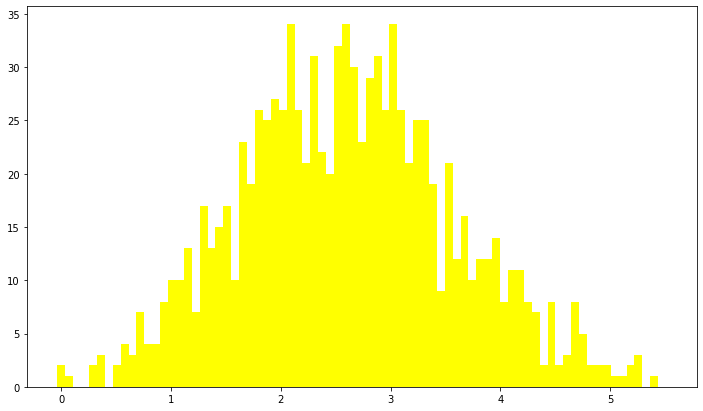

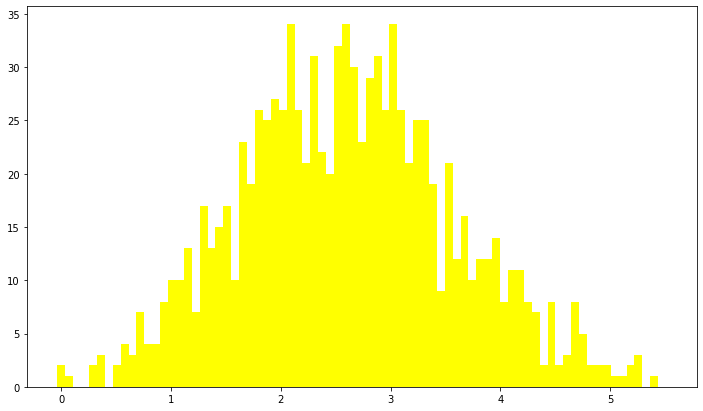

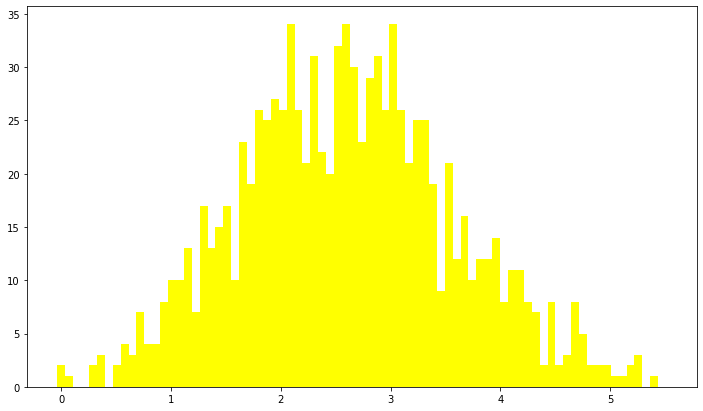

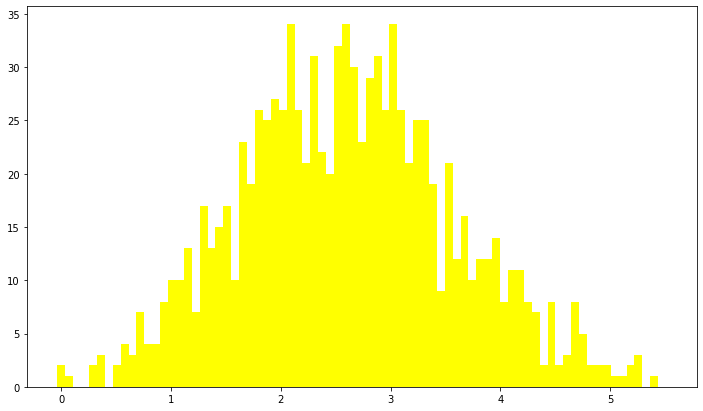

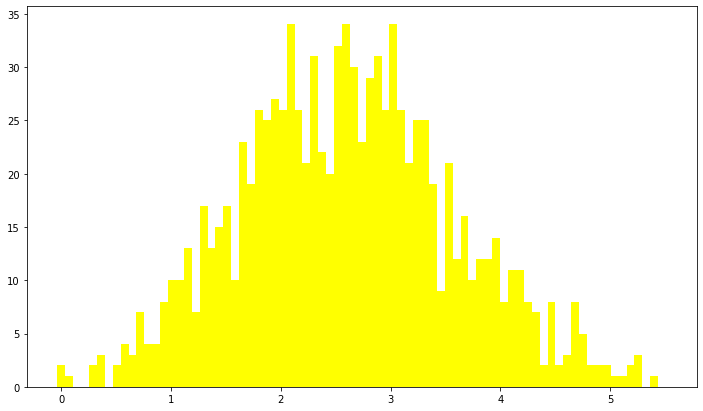

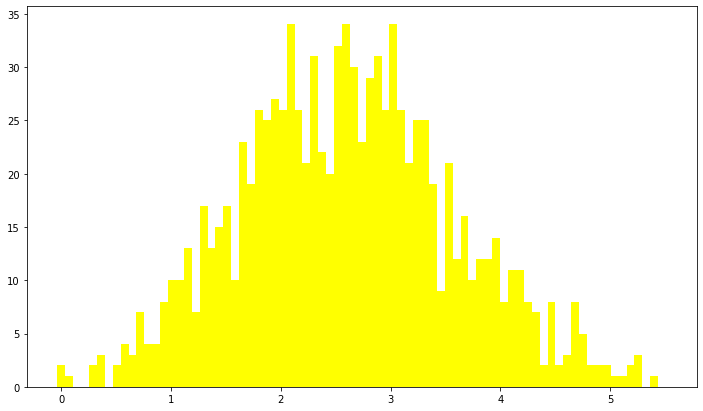

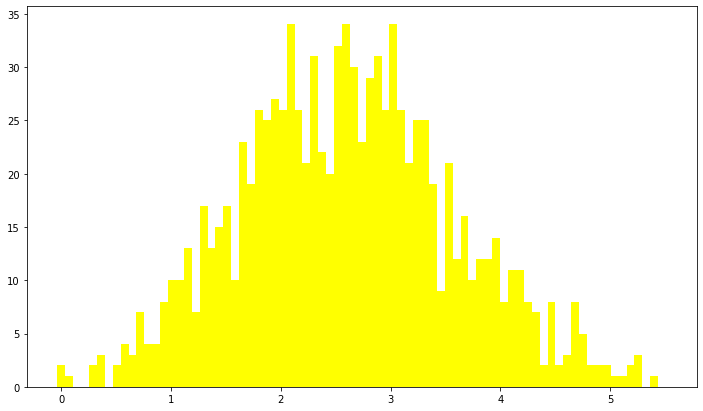

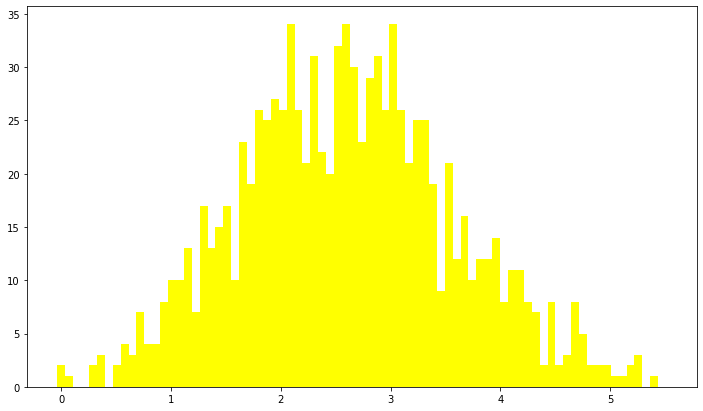

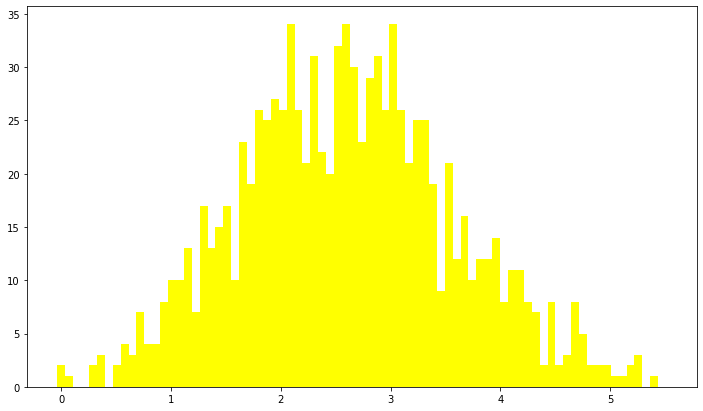

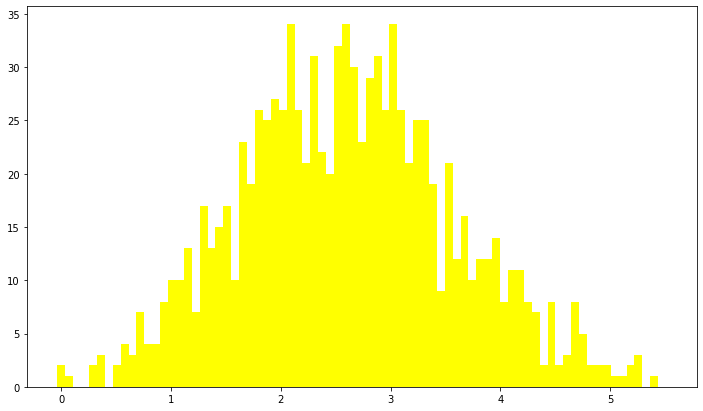

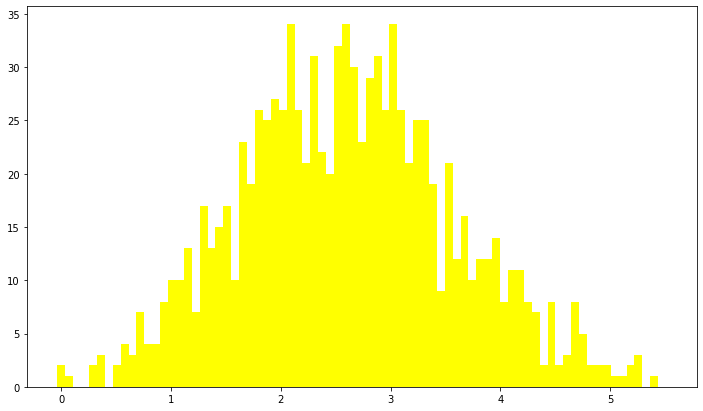

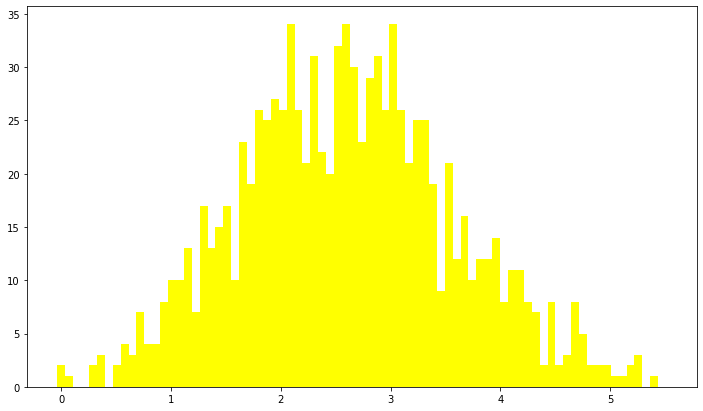

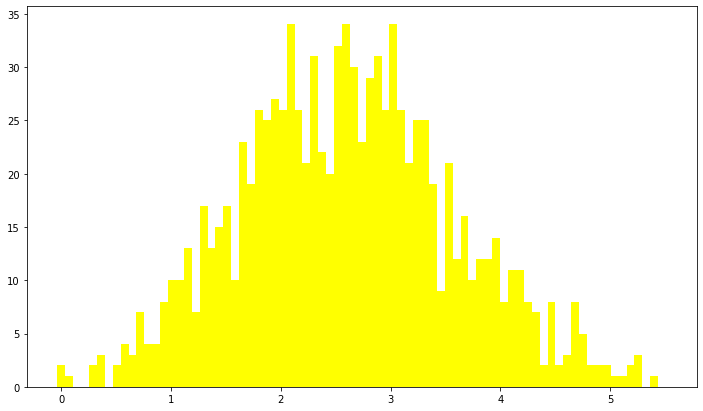

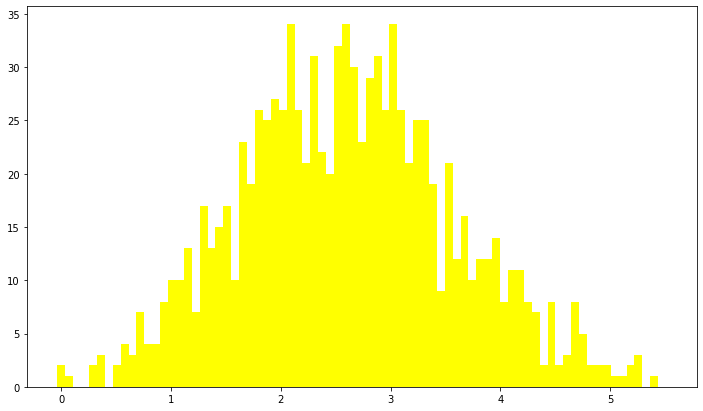

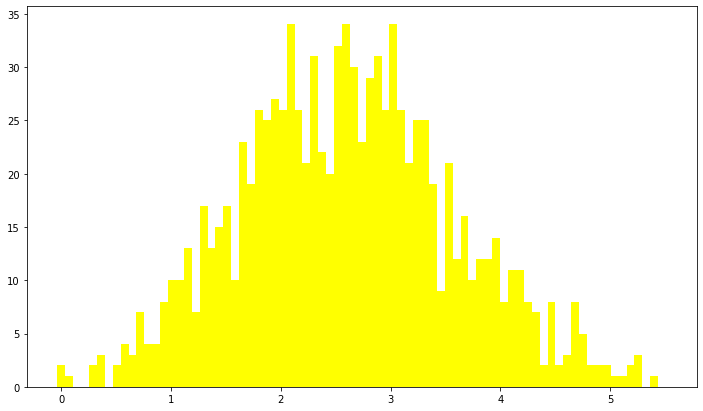

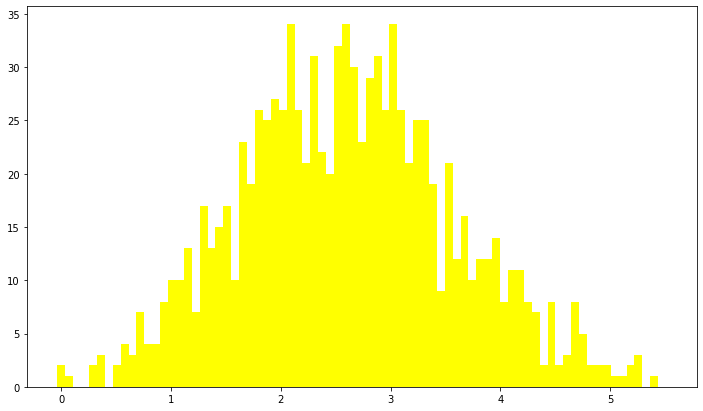

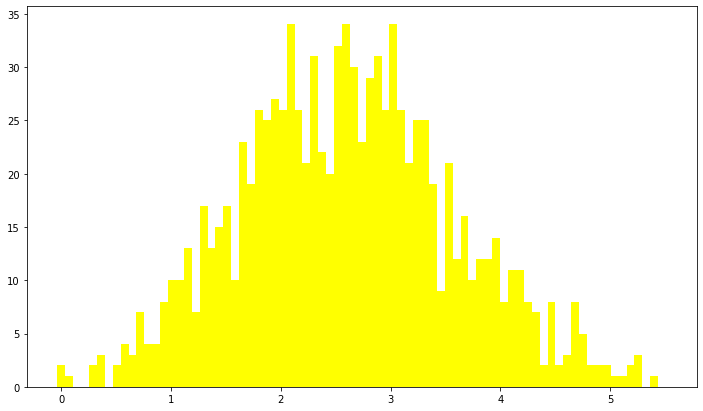

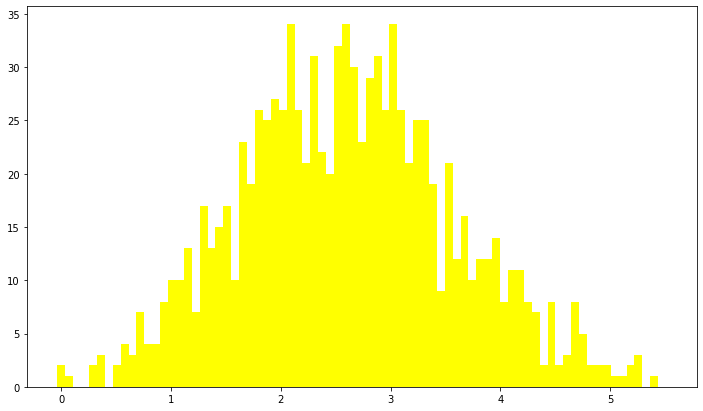

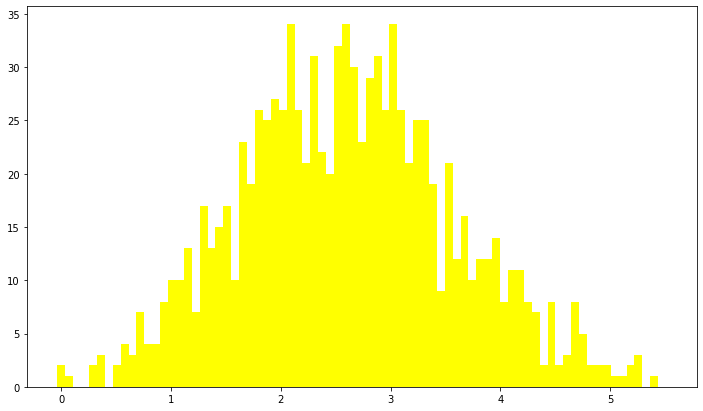

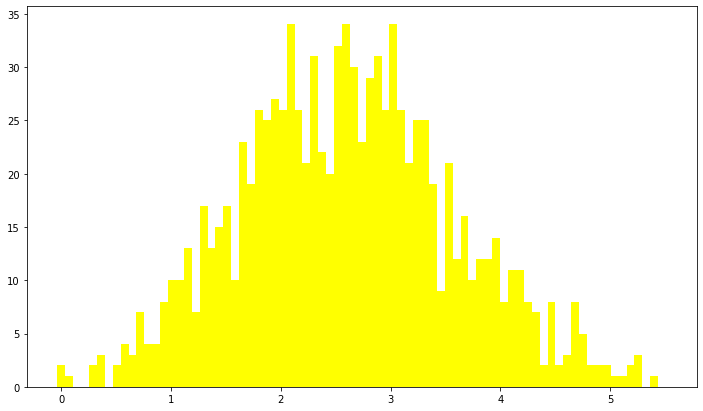

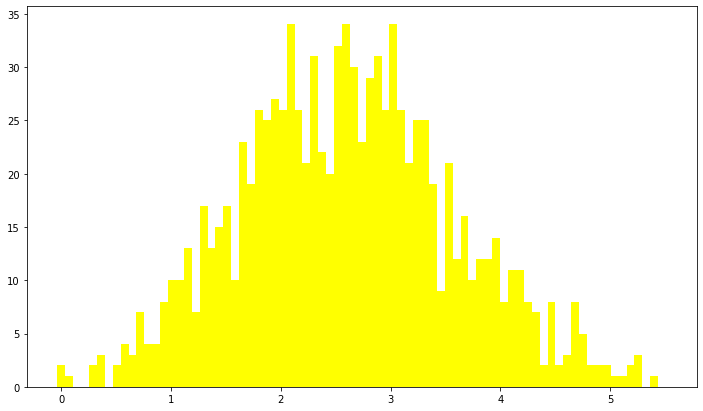

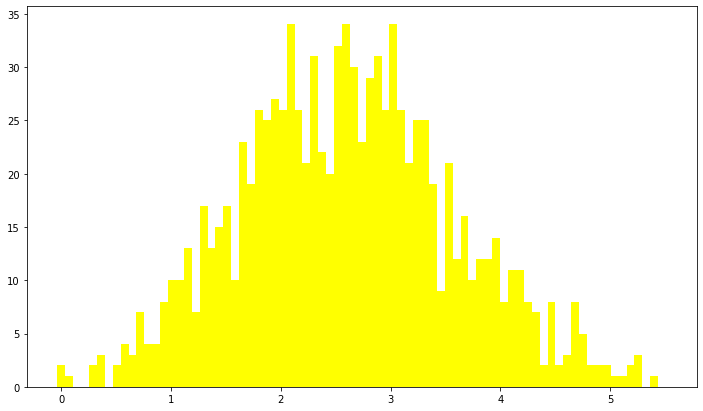

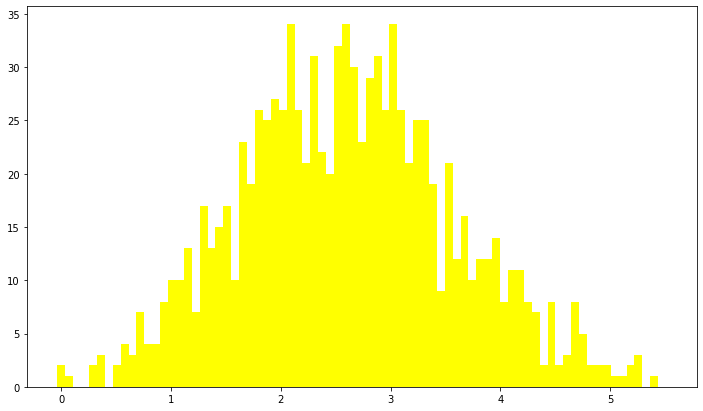

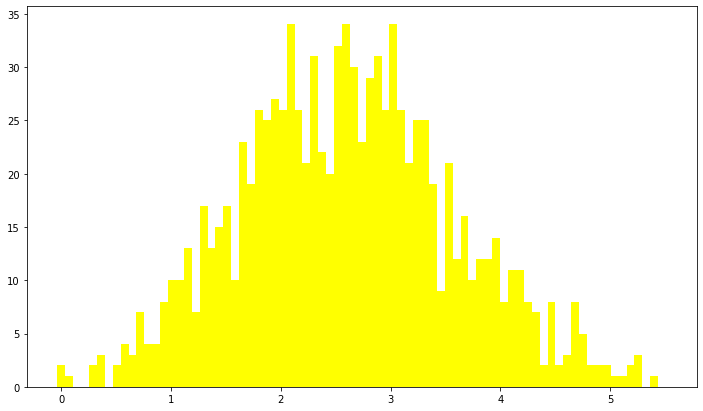

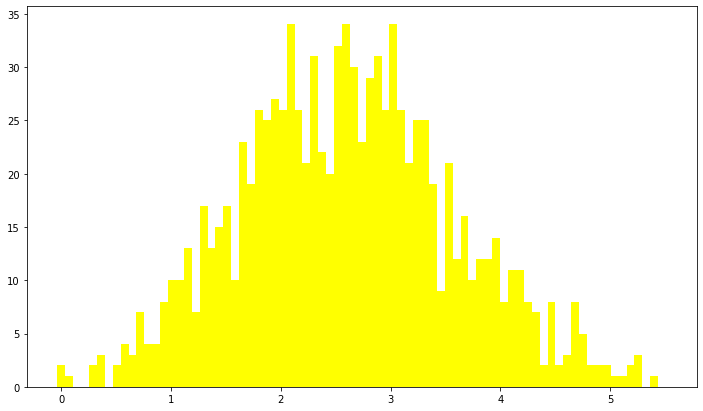

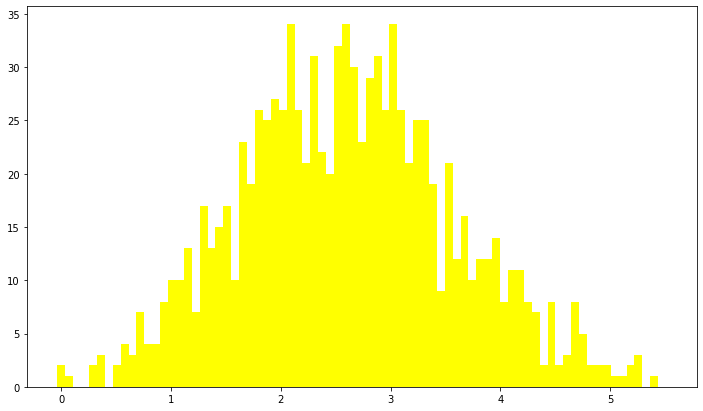

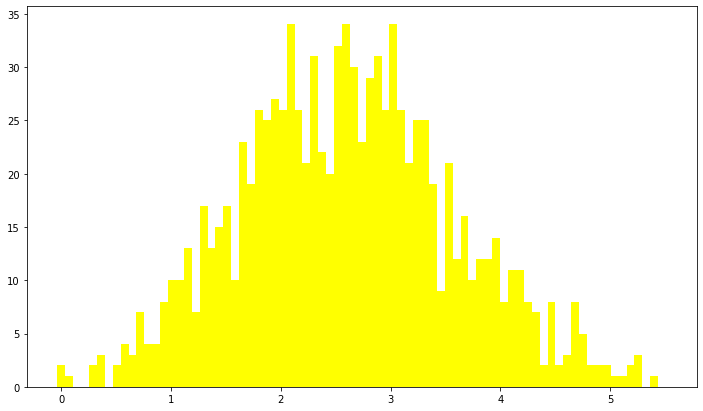

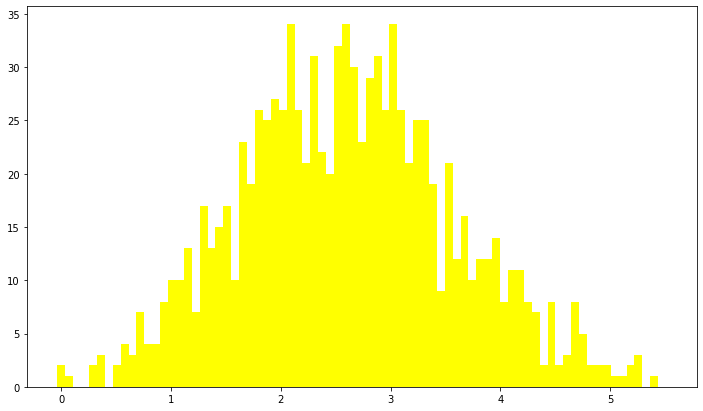

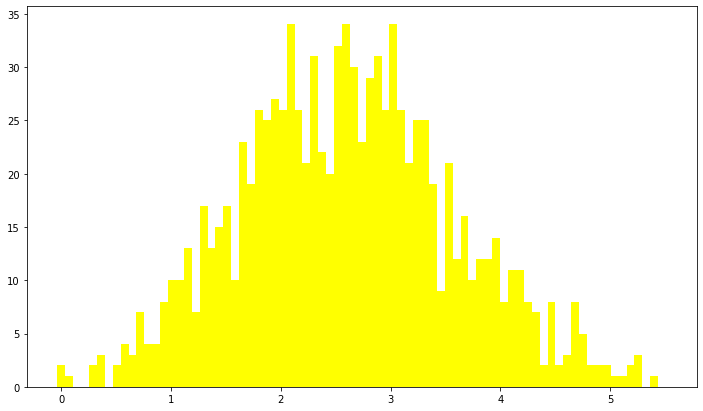

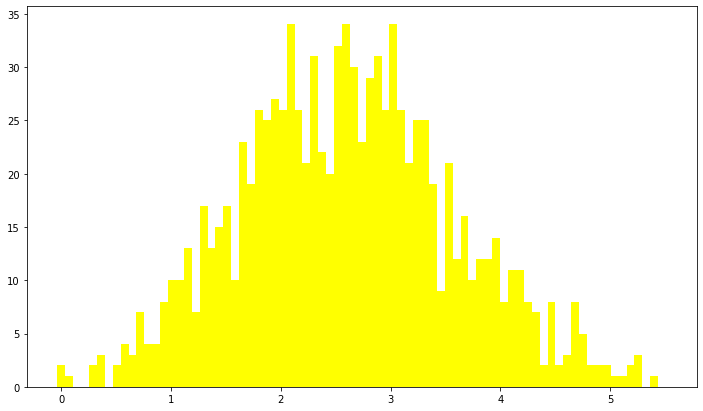

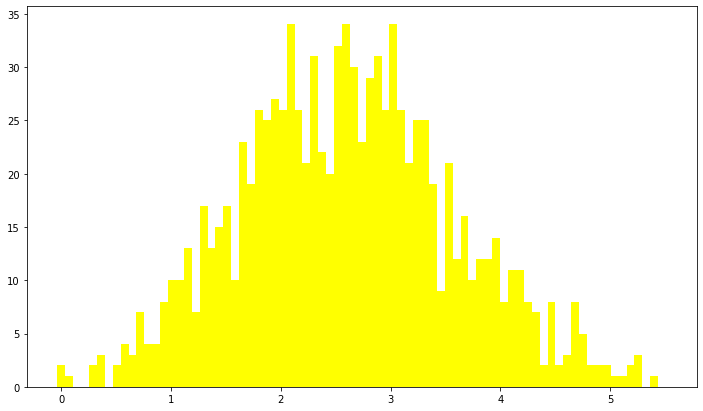

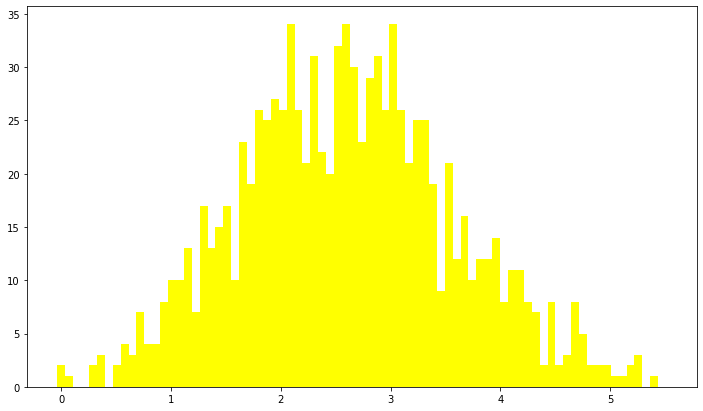

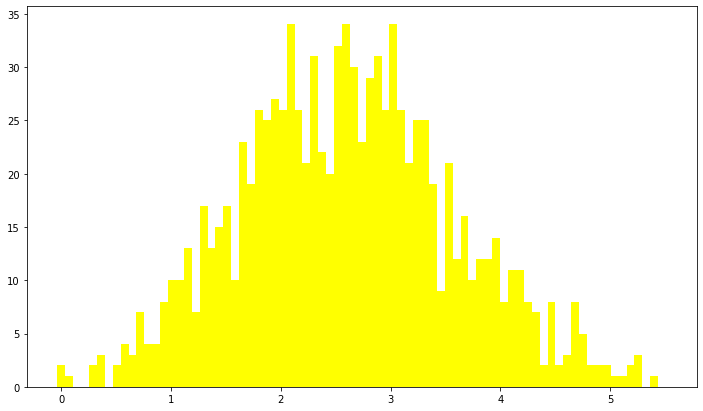

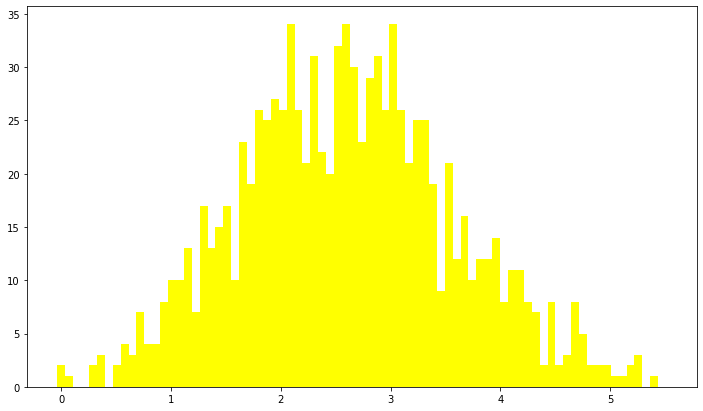

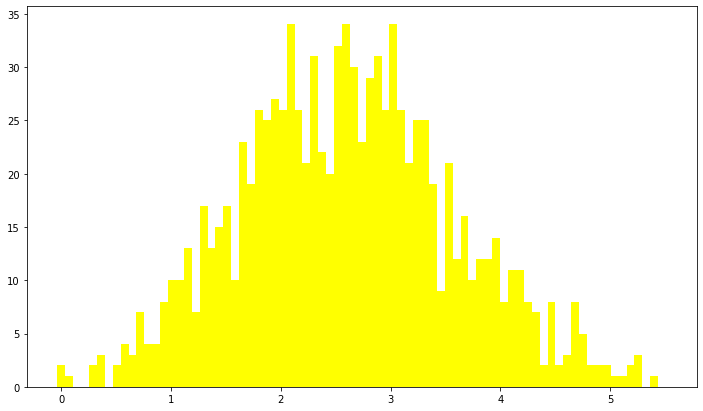

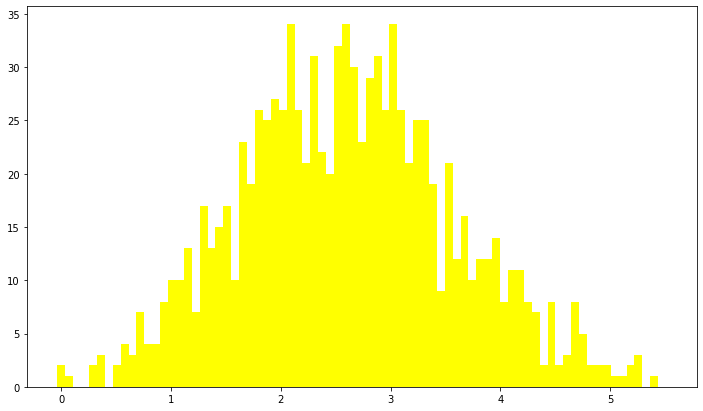

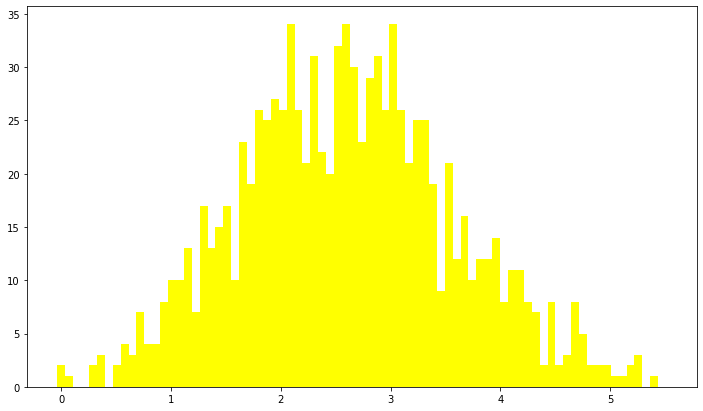

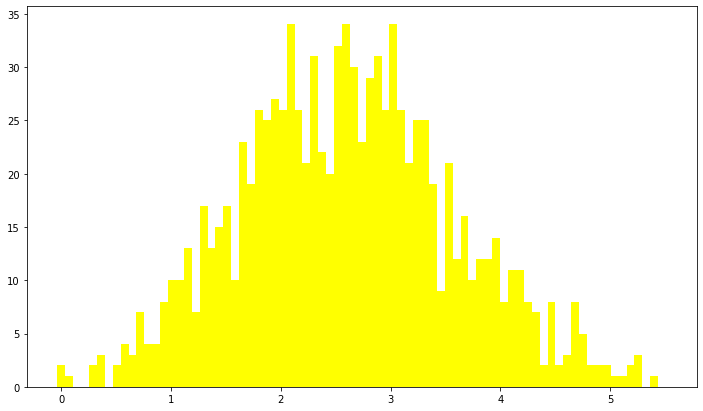

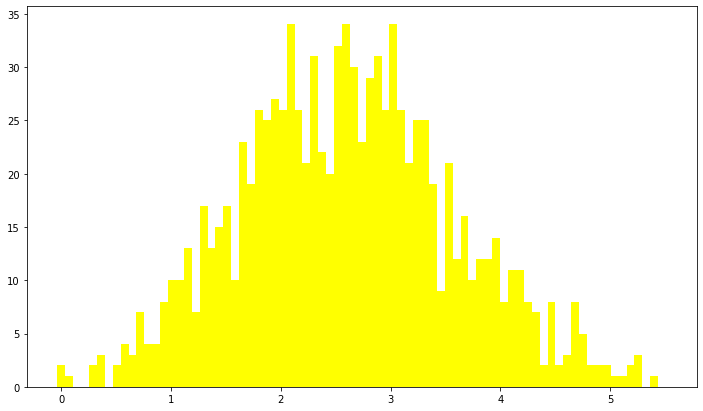

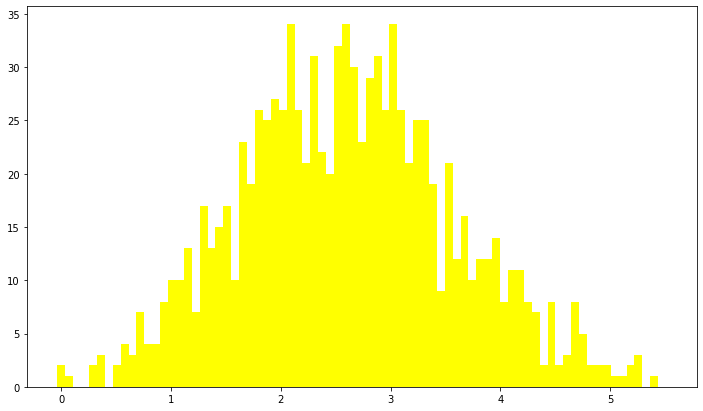

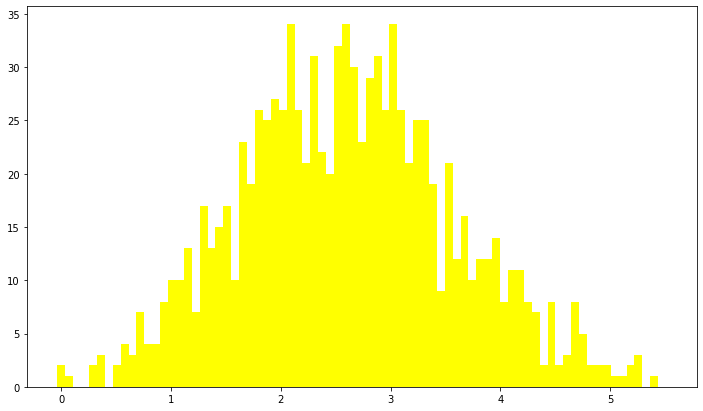

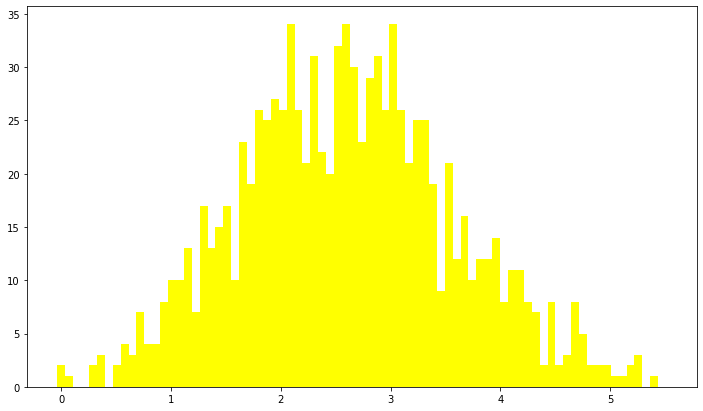

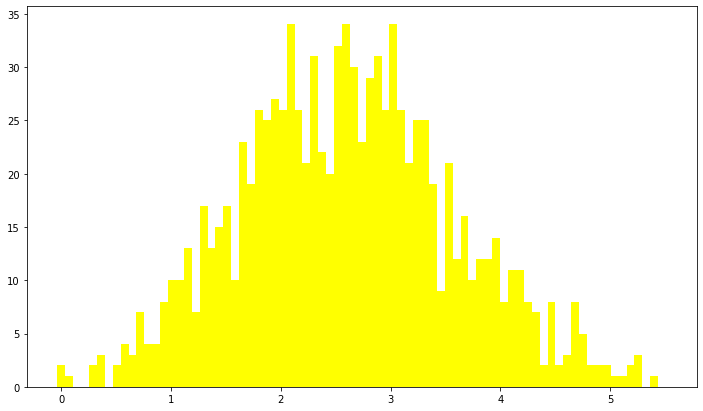

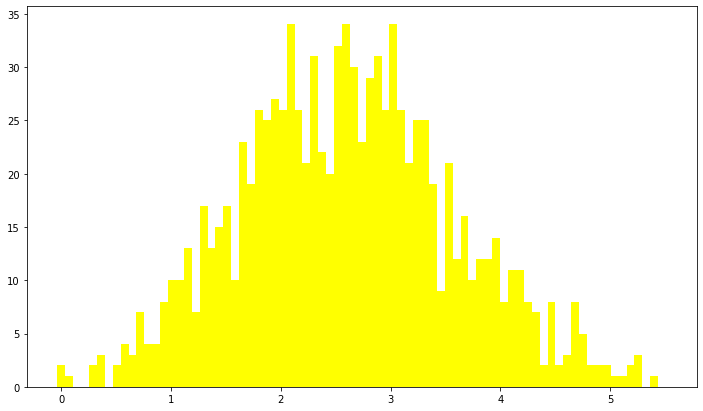

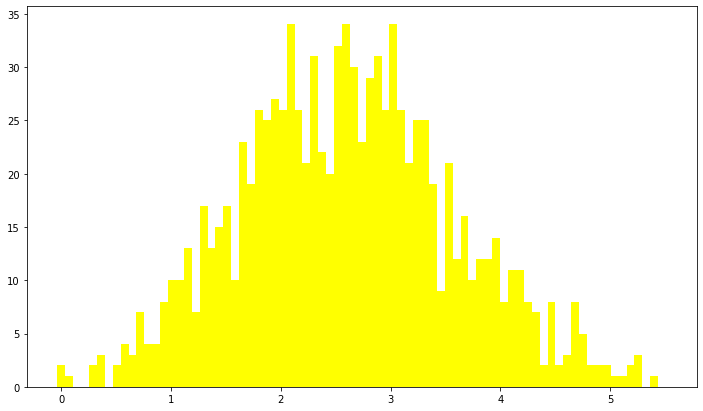

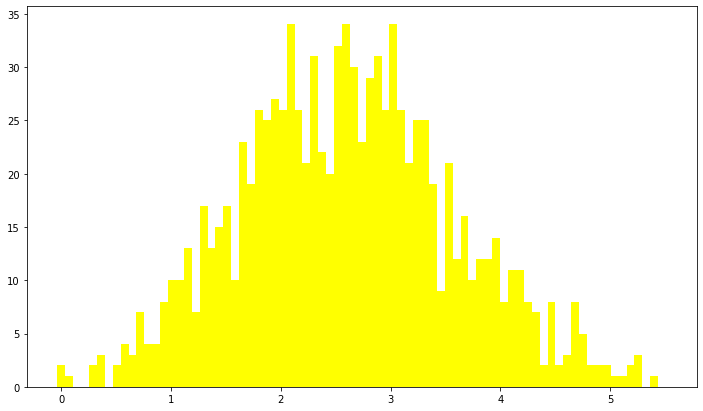

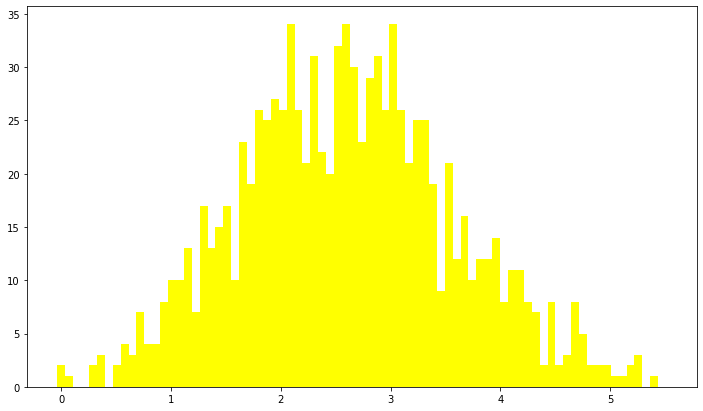

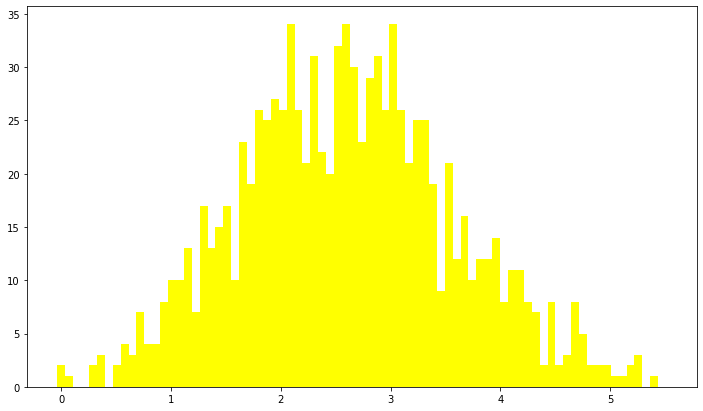

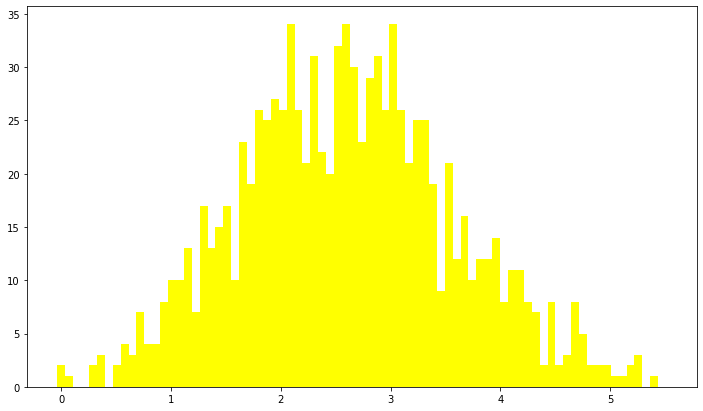

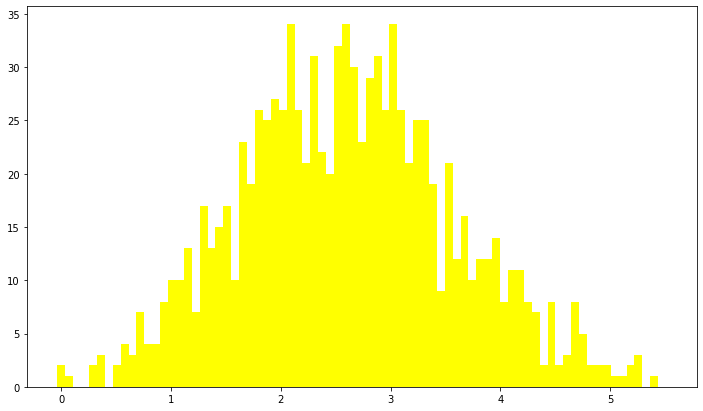

165 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
%%timeit
hs, xs = fast_hist(array, bins)
plt.bar(xs, hs, color='yellow', width=binw)
plt.show()